# **Analysis code for "Cracking the code: An evidence-based approach to teaching Python in an undergraduate earth science setting" by Campbell and Christensen et al.**

This code was used for analysis and visualization of course-related data from OCEAN 215 (Methods of oceanographic data analysis), taught in Autumn 2020 at the University of Washington. The notebook requires an Excel data file titled `All OCEAN 215 data deidentified.xlsx` (available upon reasonable request by email) containing anonymized metrics from the course.

For questions regarding the code, please contact Ethan C. Campbell at ethancc@uw.edu.

### Configuration and data loading

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import scipy.stats as stats
from datetime import datetime, timedelta

# Give Colab access to Google Drive
from google.colab import drive, auth
drive.mount('/content/drive')

# If needed to reload updated files:
# drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# Filepaths
filepath = '/content/drive/MyDrive/OCEAN 215 - Autumn \'20/Instructor documents/Paper/'
export_to = filepath + 'Current versions of plots/'

# Main data sheet, with rows by student
main_df = pd.read_excel(filepath + 'All OCEAN 215 data deidentified.xlsx',sheet_name='By student',
                        index_col='ID No.',na_values='NaN')

# Panopto data sheet (by session)
panopto_session_df = pd.read_excel(filepath + 'All OCEAN 215 data deidentified.xlsx',sheet_name='Panopto - by session',
                                   na_values='NaN')

# Panopto data sheet (by video)
panopto_video_df = pd.read_excel(filepath + 'All OCEAN 215 data deidentified.xlsx',sheet_name='Panopto - by video',
                                 na_values='NaN')

# Panopto video info
panopto_info_df = pd.read_excel(filepath + 'All OCEAN 215 data deidentified.xlsx',sheet_name='Panopto - video info',
                                index_col='Video name')

# Piazza data sheet (time series)
piazza_series_df = pd.read_excel(filepath + 'All OCEAN 215 data deidentified.xlsx',sheet_name='Piazza - time series',
                                 na_values='NaN',index_col='Date')

# Survey data (using static Excel version of spreadsheet)
survey_df = pd.read_excel(filepath + 'All OCEAN 215 data deidentified.xlsx',sheet_name='Survey categorization')

# Mid-quarter/final course evaluations
eval_df = pd.read_excel(filepath + 'All OCEAN 215 data deidentified.xlsx',sheet_name='Course evaluations',
                        index_col=[0,1,2])

### Survey categorization (Fig. 3)

In [ ]:
# Dichotomized by positive/negative responses
survey_pos_only = survey_df.iloc[0][3:]
survey_neg_only = survey_df.iloc[1][3:]

# Further divided by mid-quarter vs. end-of-quarter
survey_pos_mid = survey_df.iloc[3][3:]
survey_neg_mid = survey_df.iloc[4][3:]
survey_pos_final = survey_df.iloc[5][3:]
survey_neg_final = survey_df.iloc[6][3:]

# Sum of positive and negative responses
survey_sum = survey_pos_only + survey_neg_only

# Sort order from high to low
# (Note: manual re-ordering of entries with equal values is for aesthetics; delete if updating categorizations)
sort_indices = survey_sum.values.argsort()[::-1]
sort_indices = np.array([ 3,  6,  1,  9,  0, 8,  10,  2, 11,  7,  5,  4])

# Sort sums
survey_pos_sorted = survey_pos_only[sort_indices]
survey_neg_sorted = survey_neg_only[sort_indices]
survey_pos_mid_sorted = survey_pos_mid[sort_indices]
survey_neg_mid_sorted = survey_neg_mid[sort_indices]
survey_pos_final_sorted = survey_pos_final[sort_indices]
survey_neg_final_sorted = survey_neg_final[sort_indices]

# Labels
labels = survey_pos_sorted.keys().to_list()
labels[labels.index('Piazza')] \
  = 'Online Q&A forum (Piazza)'
labels[labels.index('Recorded lesson videos')] \
  = 'Flipped lesson videos (Panopto)'
labels[labels.index('Slide decks from recorded lessons')] \
  = 'Slide decks from flipped lessons'
labels[labels.index('In-class tutorials, activities, and live coding')] \
  = 'In-class tutorials, activities,\nand live coding'
labels[labels.index('Encouragement to use online resources / learn beyond class topics')] \
  = 'Encouragement to use online resources /\nlearn beyond class topics'
labels[labels.index('Group work in breakout rooms during class')] \
  = 'Group work in breakout rooms\nduring class'
labels[labels.index('Desire for more low-stakes opportunities to practice coding')] \
  = 'Desire for more low-stakes\nopportunities to practice coding'

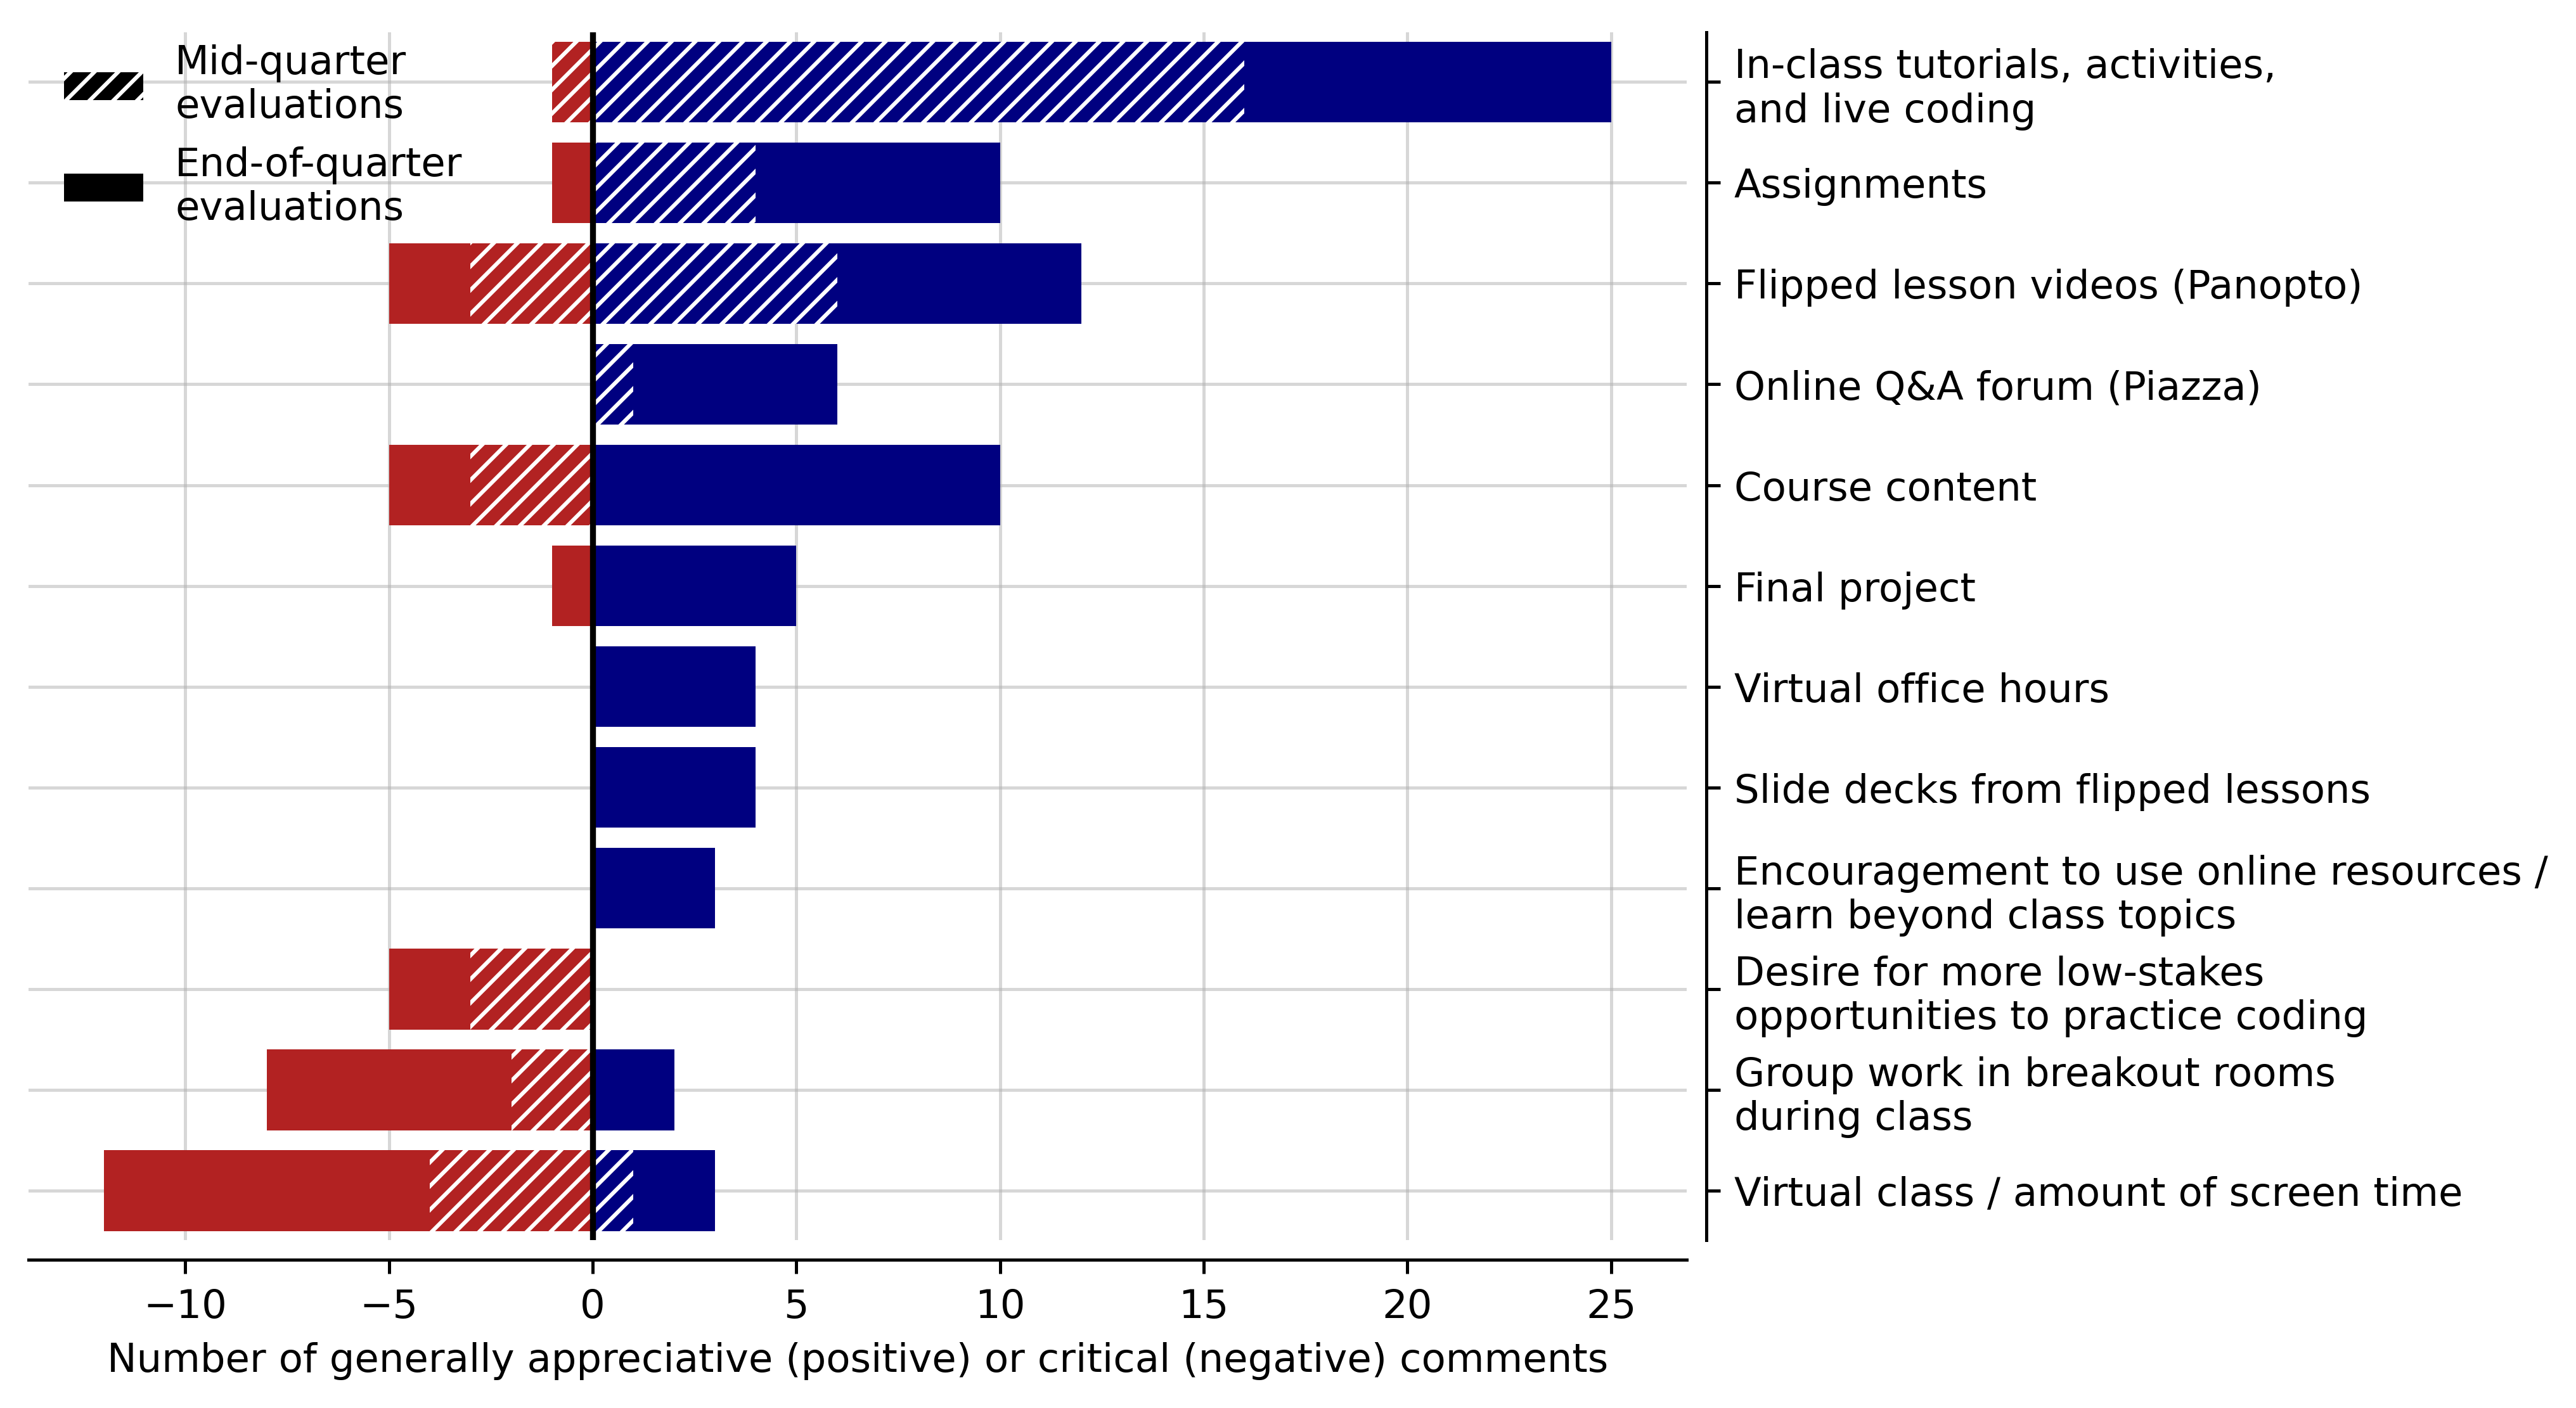

In [ ]:
# Plot
plt.figure(figsize=(7.5,5.5),facecolor='w',dpi=450)
plt.barh(y=-1*np.arange(len(survey_pos_sorted)),width=survey_pos_sorted.values,tick_label=labels,color='navy',zorder=3)
plt.barh(y=-1*np.arange(len(survey_pos_sorted)),width=survey_neg_sorted.values,color='firebrick',zorder=3)
plt.rcParams['hatch.color'] = 'w'
plt.barh(y=-1*np.arange(len(survey_pos_sorted)),width=survey_pos_mid_sorted.values,color='navy',hatch='////',zorder=4)
plt.barh(y=-1*np.arange(len(survey_pos_sorted)),width=survey_neg_mid_sorted.values,color='firebrick',hatch='////',zorder=4)
plt.barh(y=np.NaN,width=0,color='k',hatch='////',label='Mid-quarter\nevaluations')
plt.barh(y=np.NaN,width=0,color='k',label='End-of-quarter\nevaluations')
plt.gca().yaxis.set_label_position('right')
plt.gca().yaxis.tick_right()
save_ylim = plt.ylim()
plt.plot([0,0],save_ylim,c='k',zorder=4)
plt.ylim([save_ylim[0]+0.5,save_ylim[1]-0.5])
plt.grid(alpha=0.5,zorder=1)
plt.legend(loc='upper left',bbox_to_anchor=(0.0,1.02),frameon=False,fontsize='medium')
# plt.title('Responses to mid-quarter and final course evaluations')
plt.xlabel('Number of generally appreciative (positive) or critical (negative) comments')
plt.gca().spines['right'].set_position(('outward',5))
plt.gca().spines['bottom'].set_position(('outward',5))
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig(export_to + 'Survey categorization (updated).pdf',bbox_inches='tight')
plt.savefig(export_to + 'Survey categorization (updated).eps',bbox_inches='tight')

### Panopto and Piazza time series (Fig. 5a)

In [ ]:
# Key metrics
all_ids = main_df.index.values
num_students = len(all_ids)
all_video_names = np.unique(panopto_video_df['Session Name'].values)
video_median_datetimes = np.array([panopto_session_df['Timestamp'][panopto_session_df['Session Name'] == video_name].quantile(0.5,interpolation='midpoint')
                                   for video_name in all_video_names])
video_due_datetimes = panopto_info_df['Class date and time to be watched by']
panopto_info_df['Median watch datetime'] = video_median_datetimes
panopto_info_df['Due date minus median watch datetime'] = (video_due_datetimes - video_median_datetimes)

# Calculate average percent Panopto completion by video
student_vs_video_completion = pd.pivot_table(panopto_video_df,values='Percent Completed',index=['ID No.'],columns=['Session Name'],fill_value=0)

# Calculate average percent Panopto completion by lesson (which can include multiple videos; allowing this to be > 100%)
panopto_video_df['Lesson number'] = panopto_info_df['Lesson number'].loc[panopto_video_df['Session Name']].values
total_mins_delivered_by_lesson_and_student = panopto_video_df[['Lesson number','Minutes Delivered','ID No.']].groupby(['ID No.','Lesson number']).sum()
student_vs_lesson_minutes_delivered = pd.pivot_table(total_mins_delivered_by_lesson_and_student,values='Minutes Delivered',index=['ID No.'],columns=['Lesson number'],fill_value=0)

video_average_completion = student_vs_video_completion.mean(axis=0)
video_median_completion = student_vs_video_completion.median(axis=0)
video_iqr25_completion = student_vs_video_completion.quantile(axis=0,q=0.25)
video_iqr75_completion = student_vs_video_completion.quantile(axis=0,q=0.75)

video_average_completion_sorted_by_median_datetime = pd.Series(index=video_median_datetimes,data=video_average_completion.values).sort_index()
video_median_completion_sorted_by_median_datetime = pd.Series(index=video_median_datetimes,data=video_median_completion.values).sort_index()
video_iqr25_completion_sorted_by_median_datetime = pd.Series(index=video_median_datetimes,data=video_iqr25_completion.values).sort_index()
video_iqr75_completion_sorted_by_median_datetime = pd.Series(index=video_median_datetimes,data=video_iqr75_completion.values).sort_index()

video_completion_weekly_average = video_average_completion_sorted_by_median_datetime.resample('W-SAT').mean().shift(periods=-3,freq='D').dropna()
video_completion_weekly_median = video_median_completion_sorted_by_median_datetime.resample('W-SAT').mean().shift(periods=-3,freq='D').dropna()
video_completion_weekly_iqr25 = video_iqr25_completion_sorted_by_median_datetime.resample('W-SAT').mean().shift(periods=-3,freq='D').dropna()
video_completion_weekly_iqr75 = video_iqr75_completion_sorted_by_median_datetime.resample('W-SAT').mean().shift(periods=-3,freq='D').dropna()

<ipython-input-4-f9265ad65189>:9: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  panopto_info_df['Due date minus median watch datetime'] = (video_due_datetimes - video_median_datetimes)


In [ ]:
# Usage time series from Piazza metrics
piazza_daily_users_smoothed = piazza_series_df['Unique users per day'].rolling(window=3,center=True).mean()
piazza_users_per_week = piazza_series_df['Unique users per day'].resample('W-SAT').sum().shift(periods=-3,freq='D')

# Post frequency compiled by hand from Piazza
#
# "Daily questions and notes" includes questions and notes, and excludes:
#    - Posts that counted as an assignment (e.g. A#0 intro posts, final project check-ins)
#    - Questions or notes posted by instructors (e.g. A#0 template, final project templates)
# "Daily answers and comments" includes answers and comments, and excludes:
#    - Comments for an assignment (e.g. final project check-in responses, final project peer reviews)
#    - Answers or comments posted by instructors
piazza_daily_questions_notes = piazza_series_df['Student questions or notes per day (public)'].fillna(0) + \
                               piazza_series_df['Student questions or notes per day (public, anonymous)'].fillna(0) + \
                               piazza_series_df['Student questions or notes per day (private)'].fillna(0) + \
                               piazza_series_df['Student scheduling / extension / logistical requests per day (public or private)'].fillna(0)
piazza_daily_answers_comments = piazza_series_df['Student answers or comments per day (public)'].fillna(0) + \
                                piazza_series_df['Student answers or comments per day (public, anonymous)'].fillna(0) + \
                                piazza_series_df['Student answers or comments per day (private)'].fillna(0)
piazza_daily_assignment_submissions = piazza_series_df['Student assignments per day (public or private, some anonymous)'].fillna(0) + \
                                      piazza_series_df['Student comments for assignment per day (public)'].fillna(0) + \
                                      piazza_series_df['Student comments for assignment per day (public, anonymous)'].fillna(0)
piazza_daily_instructor_posts = piazza_series_df['Instructor questions or notes per day'].fillna(0) + \
                                piazza_series_df['Instructor answers or comments per day'].fillna(0)

piazza_daily_questions_notes_smoothed = piazza_daily_questions_notes.rolling(window=3,center=True).mean().loc['2020-09-27':'2020-12-20']
piazza_daily_answers_comments_smoothed = piazza_daily_answers_comments.rolling(window=3,center=True).mean().loc['2020-09-27':'2020-12-20']
piazza_daily_assignment_submissions_smoothed = piazza_daily_assignment_submissions.rolling(window=3,center=True).mean().loc['2020-09-27':'2020-12-20']
piazza_daily_instructor_posts_smoothed = piazza_daily_instructor_posts.rolling(window=3,center=True).mean().loc['2020-09-27':'2020-12-20']

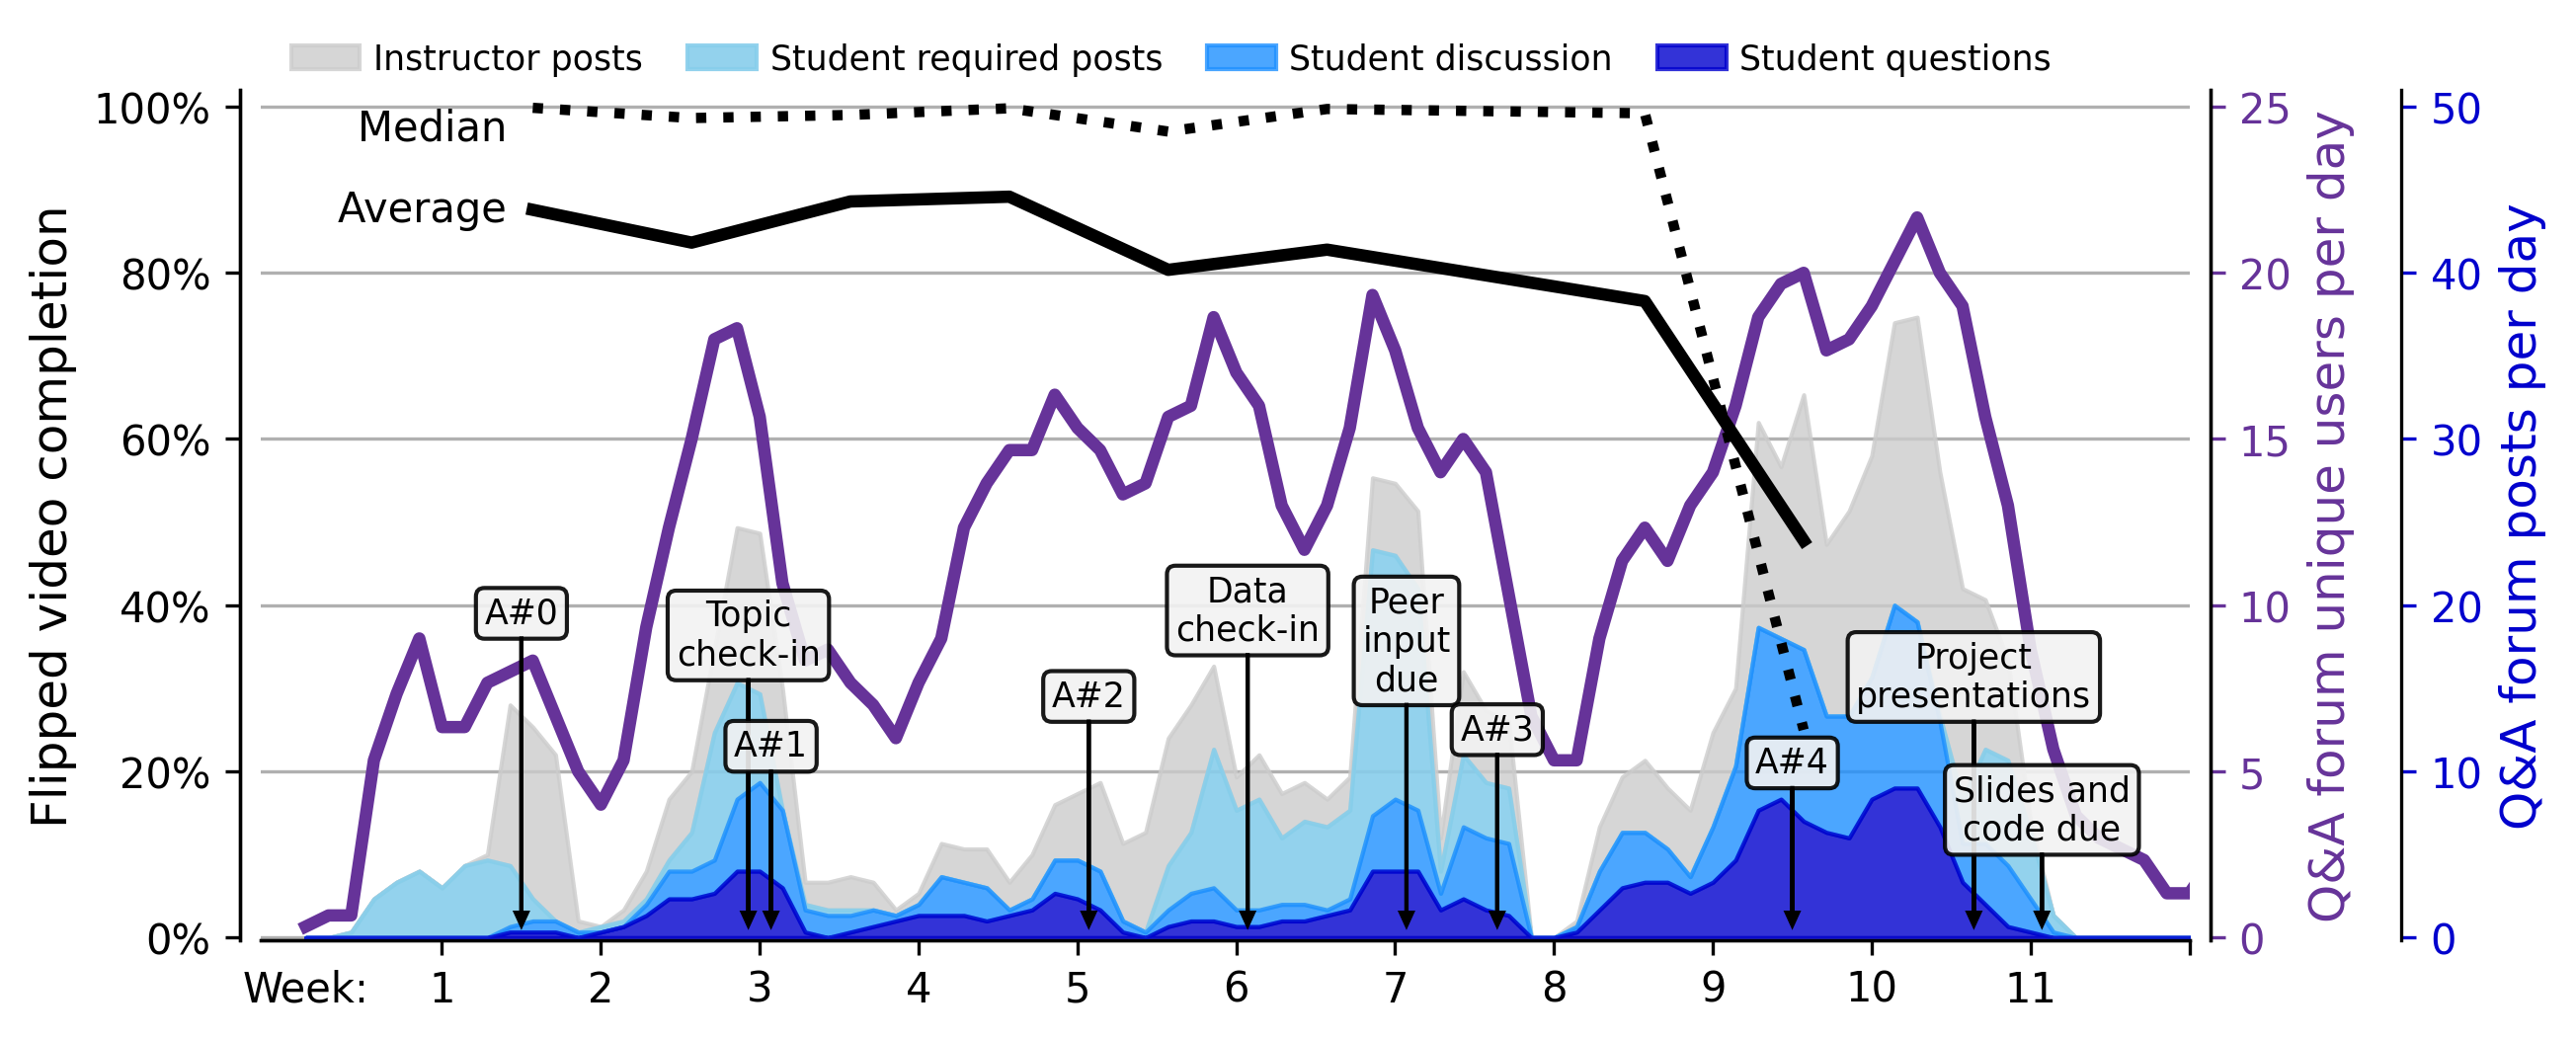

In [ ]:
# Plot time series

short_width = True   # short or long version? if short, don't include legend

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

if short_width: plt.figure(figsize=(8.4,3.8),facecolor='w',dpi=300)
else:           plt.figure(figsize=(14,7),facecolor='w',dpi=300)
ax1 = plt.gca()
p1a, = ax1.plot(video_completion_weekly_median.index,video_completion_weekly_median.values,c='k',lw=2.5,ls=':',label='Median',zorder=4)
p1b, = ax1.plot(video_completion_weekly_average.index,video_completion_weekly_average.values,c='k',lw=3,ls='-',label='Average',zorder=4)
ax1.set_ylim([-0.3,102])
if short_width: ax1.set_xlim([datetime(2020,9,25),datetime(2020,12,19)])
else:           ax1.set_xlim([datetime(2020,9,25),datetime(2020,12,22)])
ax1.set_ylabel('Flipped video completion',fontsize='large')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
if short_width: line_labels = ['Median  ','Average  ']; fontsize = 'medium'
else:           line_labels = ['Median   ','Average   ']; fontsize = 'large'
ax1.text(video_completion_weekly_median.index[0],video_completion_weekly_median.values[0],line_labels[0],
         horizontalalignment='right',verticalalignment='top',fontsize=fontsize,c='k')
ax1.text(video_completion_weekly_average.index[0],video_completion_weekly_average.values[0],line_labels[1],
         horizontalalignment='right',verticalalignment='center',fontsize=fontsize,c='k')
ax1.set_zorder(3)
ax1.patch.set_visible(False)

ax2 = ax1.twinx()
p2, = ax2.plot(piazza_daily_users_smoothed.loc['2020-09-27':'2020-12-22'],c='rebeccapurple',lw=3,zorder=3)
ax2.set_ylim([-0.075,25.5])
ax2.yaxis.label.set_color(p2.get_color())
ax2.tick_params(axis='y',colors=p2.get_color())
ax2.set_ylabel('Q&A forum unique users per day',fontsize='large')
ax2.set_zorder(1)
ax2.patch.set_visible(False)
ax2.grid(axis='y',zorder=-1)

ax3 = ax1.twinx()
if short_width: ax3.spines['right'].set_position(('axes',1.11))
else:           ax3.spines['right'].set_position(('axes',1.09))
make_patch_spines_invisible(ax3)
ax3.spines['right'].set_visible(True)
ax3.fill_between(piazza_daily_questions_notes_smoothed.index,piazza_daily_questions_notes_smoothed + piazza_daily_answers_comments_smoothed + piazza_daily_assignment_submissions_smoothed,
                 piazza_daily_questions_notes_smoothed + piazza_daily_answers_comments_smoothed + piazza_daily_assignment_submissions_smoothed + piazza_daily_instructor_posts_smoothed,
                 color='0.8',alpha=0.8,zorder=2,label='Instructor posts')
ax3.fill_between(piazza_daily_questions_notes_smoothed.index,piazza_daily_questions_notes_smoothed + piazza_daily_answers_comments_smoothed,
                 piazza_daily_questions_notes_smoothed + piazza_daily_answers_comments_smoothed + piazza_daily_assignment_submissions_smoothed,
                 color='skyblue',alpha=0.9,zorder=2,label='Student required posts')
if short_width: shade_label = 'Student discussion'
else:           shade_label = 'Student answers and comments'
ax3.fill_between(piazza_daily_questions_notes_smoothed.index,piazza_daily_questions_notes_smoothed,
                 piazza_daily_questions_notes_smoothed + piazza_daily_answers_comments_smoothed,
                 color='dodgerblue',alpha=0.8,zorder=2,label=shade_label)
if short_width: shade_label = 'Student questions'
else:           shade_label = 'Student questions and notes'
ax3.fill_between(piazza_daily_questions_notes_smoothed.index,piazza_daily_questions_notes_smoothed,
                 color='mediumblue',alpha=0.8,zorder=2,label=shade_label)
ax3.set_ylim([-0.15,51])
if short_width: plt.legend(loc='lower left',frameon=False,ncol=4,fontsize='small',handletextpad=0.4,columnspacing=1.3,bbox_to_anchor=(0.0,0.98))
else:           plt.legend(loc='upper right',frameon=True)
ax3.yaxis.label.set_color('mediumblue')
ax3.tick_params(axis='y',colors='mediumblue')
ax3.set_ylabel('Q&A forum posts per day',fontsize='large')
ax3.set_zorder(2)
ax3.patch.set_visible(False)

def arrow_label(dt,lift,zorder,label):
  ax3.arrow(dt,lift,0,-(lift-1.5),color='k',head_width=0.5,zorder=5+zorder)
  if short_width: fontsize = 'small'
  else:           fontsize = 'medium'
  tx = ax3.text(dt,lift+0.5,label,horizontalalignment='center',verticalalignment='bottom',fontsize=fontsize,c='k',
                bbox=dict(facecolor='0.95',alpha=0.9,boxstyle='round,pad=0.25'))
  tx.set_zorder(5+zorder)

arrow_label(datetime(2020,10,6,11,59),18,1,'A#0')
arrow_label(datetime(2020,10,16,11,59),15.5,2,'Topic\ncheck-in')
arrow_label(datetime(2020,10,17,11,59),10,3,'A#1')
arrow_label(datetime(2020,10,31,11,59),13,4,'A#2')
arrow_label(datetime(2020,11,7,11,59),17,5,'Data\ncheck-in')
arrow_label(datetime(2020,11,14,11,59),14,6,'Peer\ninput\ndue')
arrow_label(datetime(2020,11,18,11,59),11,7,'A#3')
arrow_label(datetime(2020,12,1,11,59),9,8,'A#4')
arrow_label(datetime(2020,12,9,11,59),13,9,'Project\npresentations')
arrow_label(datetime(2020,12,12,11,59),5,10,'Slides and\ncode due')

ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.SATURDAY))
xticks = ax1.xaxis.get_major_ticks()
xticks[0].set_visible(False)
ax1.xaxis.set_ticklabels(['',*['{0}'.format(i) for i in range(1,11+1)],'']);
if short_width: week_label_drop = -3.1
else:           week_label_drop = -1.8
plt.text(datetime(2020,9,27),week_label_drop,'Week:',verticalalignment='center',horizontalalignment='center');

ax1.spines['left'].set_position(('outward',5))
ax2.spines['left'].set_position(('outward',5))
ax1.spines['right'].set_position(('outward',5))
ax2.spines['right'].set_position(('outward',5))
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.savefig(export_to + 'Panopto and Piazza time series.pdf',bbox_inches='tight')

### Piazza post type and audience (Fig. 5b)

In [ ]:
# Totals
piazza_series_df_manual_counts = piazza_series_df.iloc[:,list(piazza_series_df.keys()).index('Student questions or notes per day (public)'):]
print('Total Piazza posts:',int(piazza_series_df_manual_counts.sum().sum()))
piazza_series_df_student_count = np.sum([piazza_series_df[key].sum() for key in piazza_series_df.keys() if 'Student' in key])
print('Total Piazza posts from students:',piazza_series_df_student_count)

# Breakdown of all Piazza post types by students and instructors
pie_main = {'Student questions and notes' : piazza_series_df['Student questions or notes per day (public)'].sum() + \
                                           piazza_series_df['Student questions or notes per day (public, anonymous)'].sum() + \
                                           piazza_series_df['Student questions or notes per day (private)'].sum(),
            'Student scheduling,\nextension, and\nlogistical questions' : piazza_series_df['Student scheduling / extension / logistical requests per day (public or private)'].sum(),
            'Student answers\nand comments' : piazza_series_df['Student answers or comments per day (public)'].sum() + \
                                            piazza_series_df['Student answers or comments per day (public, anonymous)'].sum() + \
                                            piazza_series_df['Student answers or comments per day (private)'].sum(),
            'Student required posts' : piazza_series_df['Student comments for assignment per day (public)'].sum() + \
                                       piazza_series_df['Student comments for assignment per day (public, anonymous)'].sum() + \
                                       piazza_series_df['Student assignments per day (public or private, some anonymous)'].sum(),
            'Instructor posts,\nanswers, and comments' : piazza_series_df['Instructor questions or notes per day'].sum() + \
                                                        piazza_series_df['Instructor answers or comments per day'].sum()}

pie_main_keys = np.array(list(pie_main.keys()))
pie_main_vals = np.array(list(pie_main.values()))
pie_main_colors = ['mediumblue','mediumblue','dodgerblue','skyblue','0.8']
pie_main_alpha = [0.8,0.8,0.8,0.9,0.8]
pie_main_hatch = [None,'||',None,None,None]
pie_main_label2_colors = ['w','w','w','k','k']

# Breakdown of all Piazza posts by audience
pie_main_audience = [piazza_series_df['Student questions or notes per day (public)'].sum(),
                     piazza_series_df['Student questions or notes per day (public, anonymous)'].sum(),
                     piazza_series_df['Student questions or notes per day (private)'].sum(),
                     piazza_series_df['Student scheduling / extension / logistical requests per day (public or private)'].sum(),
                     piazza_series_df['Student answers or comments per day (public)'].sum(),
                     piazza_series_df['Student answers or comments per day (public, anonymous)'].sum(),
                     piazza_series_df['Student answers or comments per day (private)'].sum(),
                     piazza_series_df['Student assignments per day (public or private, some anonymous)'].sum(),
                     piazza_series_df['Student comments for assignment per day (public)'].sum(),
                     piazza_series_df['Student comments for assignment per day (public, anonymous)'].sum(),
                     piazza_series_df['Instructor questions or notes per day'].sum() + \
                         piazza_series_df['Instructor answers or comments per day'].sum()]
pmac_indices = [0,1,2,3,0,1,2,3,0,1,3]
pma_colors = ['darkgoldenrod','goldenrod','palegoldenrod','0.95']
pie_main_audience_colors = [pma_colors[idx] for idx in pmac_indices]

# Audience of non-required Piazza questions, notes, answers, and comments by students
pie_audience = {'Public signed posts' : piazza_series_df['Student questions or notes per day (public)'].sum() + \
                                        piazza_series_df['Student answers or comments per day (public)'].sum(),
                'Public anonymous posts' : piazza_series_df['Student questions or notes per day (public, anonymous)'].sum() + \
                                           piazza_series_df['Student answers or comments per day (public, anonymous)'].sum(),
                'Private posts (to instructors only)' : piazza_series_df['Student questions or notes per day (private)'].sum() + \
                                                        piazza_series_df['Student answers or comments per day (private)'].sum()}

pie_audience_keys = np.array(list(pie_audience.keys()))
pie_audience_vals = np.array(list(pie_audience.values()))

Total Piazza posts: 889
Total Piazza posts from students: 530.0


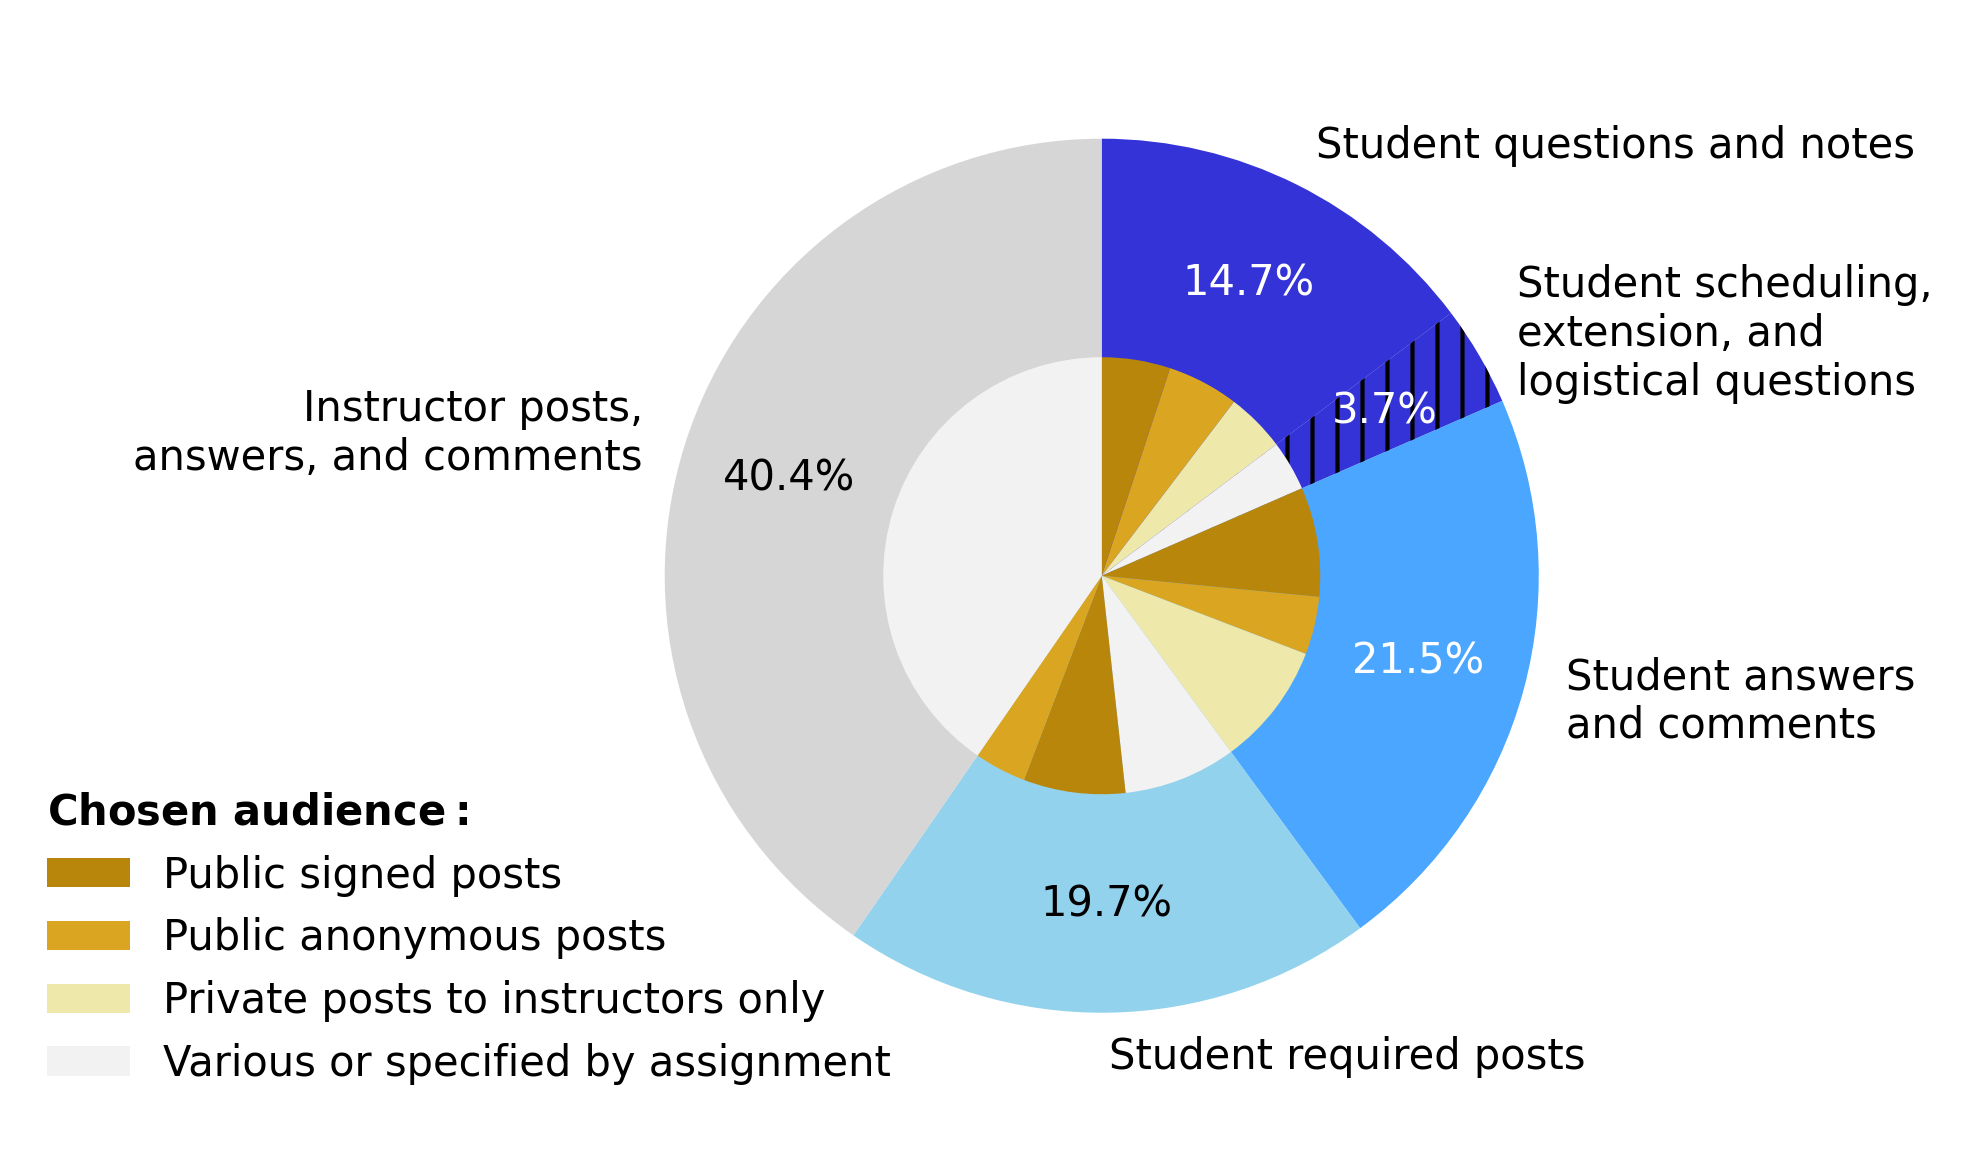

In [ ]:
# Plot
plt.rcParams['hatch.color'] = 'k'
plt.figure(figsize=(6,6),facecolor='w',dpi=300)
patches, labels1, labels2 = plt.pie(pie_main_vals,labels=pie_main_keys,colors=pie_main_colors,autopct='%.1f%%',pctdistance=0.75,
                                    startangle=90,counterclock=False,frame=True)
for patch_idx, patch in enumerate(patches):
  patch.set_hatch(pie_main_hatch[patch_idx])
  patch.set_alpha(pie_main_alpha[patch_idx])
for label2_idx, label2 in enumerate(labels2): label2.set_color(pie_main_label2_colors[label2_idx])
patches, labels1 = plt.pie(pie_main_audience,colors=pie_main_audience_colors,radius=0.5,
                           startangle=90,counterclock=False)
plt.gca().set_axis_off()
plt.tight_layout()
leg = plt.legend(patches[0:4],['Public signed posts','Public anonymous posts','Private posts to instructors only','Various or specified by assignment'],
                 title='$\\bf{Chosen~audience:}$',loc='lower left',bbox_to_anchor=(-0.5,0,0,1),frameon=False)
leg._legend_box.align = 'left'
plt.savefig(export_to + 'Piazza post type and audience.pdf',bbox_inches='tight')

### Panopto analysis (Fig. 4, Fig. S2)

In [ ]:
# Cross-reference column values (add video-specific metrics to each session and video summary entry)
panopto_session_df['Date and time released'] = panopto_info_df.loc[panopto_session_df['Session Name']]['Date and time released'].values
panopto_session_df['Class date and time to be watched by'] = panopto_info_df.loc[panopto_session_df['Session Name']]['Class date and time to be watched by'].values
panopto_session_df['Duration (fractional minutes)'] = panopto_info_df.loc[panopto_session_df['Session Name']]['Duration (fractional minutes)'].values
panopto_video_df['Date and time released'] = panopto_info_df.loc[panopto_video_df['Session Name']]['Date and time released'].values
panopto_video_df['Class date and time to be watched by'] = panopto_info_df.loc[panopto_video_df['Session Name']]['Class date and time to be watched by'].values
panopto_video_df['Duration (fractional minutes)'] = panopto_info_df.loc[panopto_video_df['Session Name']]['Duration (fractional minutes)'].values

In [ ]:
# Calculate new metrics by Panopto session and video summary
panopto_session_df['Watch timing relative to release date'] = panopto_session_df['Timestamp'] - panopto_session_df['Date and time released']
panopto_session_df['Watch timing relative to due date'] = panopto_session_df['Timestamp'] - panopto_session_df['Class date and time to be watched by']

# Panopto video release distribution relative to class
release_timing = (panopto_info_df['Date and time released'] - panopto_info_df['Class date and time to be watched by']) / timedelta(days=1)
release_iqr25 = release_timing.quantile(q=0.25)
release_median = release_timing.median()
release_iqr75 = release_timing.quantile(q=0.75)

In [ ]:
# Panopto before/after class metrics
only_views_before_class = panopto_session_df[panopto_session_df['Watch timing relative to due date'] / timedelta(days=1) <= 0]
only_views_after_class = panopto_session_df[panopto_session_df['Watch timing relative to due date'] / timedelta(days=1) > 0]
mins_before_class_by_lesson_and_student = only_views_before_class[['Session Name','Minutes Delivered','ID No.']].groupby(['ID No.','Session Name']).sum()
mins_after_class_by_lesson_and_student = only_views_after_class[['Session Name','Minutes Delivered','ID No.']].groupby(['ID No.','Session Name']).sum()
student_vs_lesson_minutes_delivered_before_class = pd.pivot_table(mins_before_class_by_lesson_and_student,values='Minutes Delivered',index=['ID No.'],columns=['Session Name'],fill_value=0)
student_vs_lesson_minutes_delivered_after_class = pd.pivot_table(mins_after_class_by_lesson_and_student,values='Minutes Delivered',index=['ID No.'],columns=['Session Name'],fill_value=0)
total_lesson_minutes_delivered_before_class = student_vs_lesson_minutes_delivered_before_class.sum(axis=1).reindex(all_ids,fill_value=0)
total_lesson_minutes_delivered_after_class = student_vs_lesson_minutes_delivered_after_class.sum(axis=1).reindex(all_ids,fill_value=0)

# Panopto re-watch metric
rewatch_mask = (student_vs_lesson_minutes_delivered_before_class > 0)
total_lesson_minutes_delivered_after_class_rewatches = student_vs_lesson_minutes_delivered_after_class[rewatch_mask].sum(axis=1).reindex(all_ids,fill_value=0)

# Minutes after class: fraction that were re-watches vs. first-time watches
after_class_percent_first_time = (total_lesson_minutes_delivered_after_class.sum() - total_lesson_minutes_delivered_after_class_rewatches.sum()) / panopto_session_df['Minutes Delivered'].sum()
after_class_percent_rewatch = total_lesson_minutes_delivered_after_class_rewatches.sum() / panopto_session_df['Minutes Delivered'].sum()
print('{0:.2f}% of Panopto minutes watched after class were first-time watches'.format(100*after_class_percent_first_time))
print('{0:.2f}% of Panopto minutes watched after class were re-watches'.format(100*after_class_percent_rewatch))

print('Half of all re-watched minutes = {0:.2f} minutes'.format(total_lesson_minutes_delivered_after_class_rewatches.sum()/2))
print('{0} students accounted for over half of all re-watched minutes'.format(np.where(total_lesson_minutes_delivered_after_class_rewatches.sort_values(ascending=False).cumsum() >
                                                                                       total_lesson_minutes_delivered_after_class_rewatches.sum()/2)[0][0] + 1))

# Additional metrics for figure
panopto_lesson_counts = panopto_info_df['Duration (fractional minutes)'].groupby(panopto_info_df['Lesson number']).count()
panopto_lesson_durations = panopto_info_df['Duration (fractional minutes)'].groupby(panopto_info_df['Lesson number']).sum()
student_vs_video_delivery = pd.pivot_table(panopto_video_df,values='Minutes Delivered',
                                           index=['ID No.'],columns=['Session Name'],fill_value=0)
video_percent_delivery = 100 * student_vs_video_delivery.mean(axis=0) / panopto_info_df['Duration (fractional minutes)']
lesson_percent_delivery = 100 * student_vs_lesson_minutes_delivered.mean(axis=0) / panopto_lesson_durations

26.84% of Panopto minutes watched after class were first-time watches
7.56% of Panopto minutes watched after class were re-watches
Half of all re-watched minutes = 377.41 minutes
3 students accounted for over half of all re-watched minutes


<ipython-input-13-74f6e6085c16>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([str(int(val)) for val in correct_xtick_labels])
<ipython-input-13-74f6e6085c16>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(100*val) for val in plt.yticks()[0]])


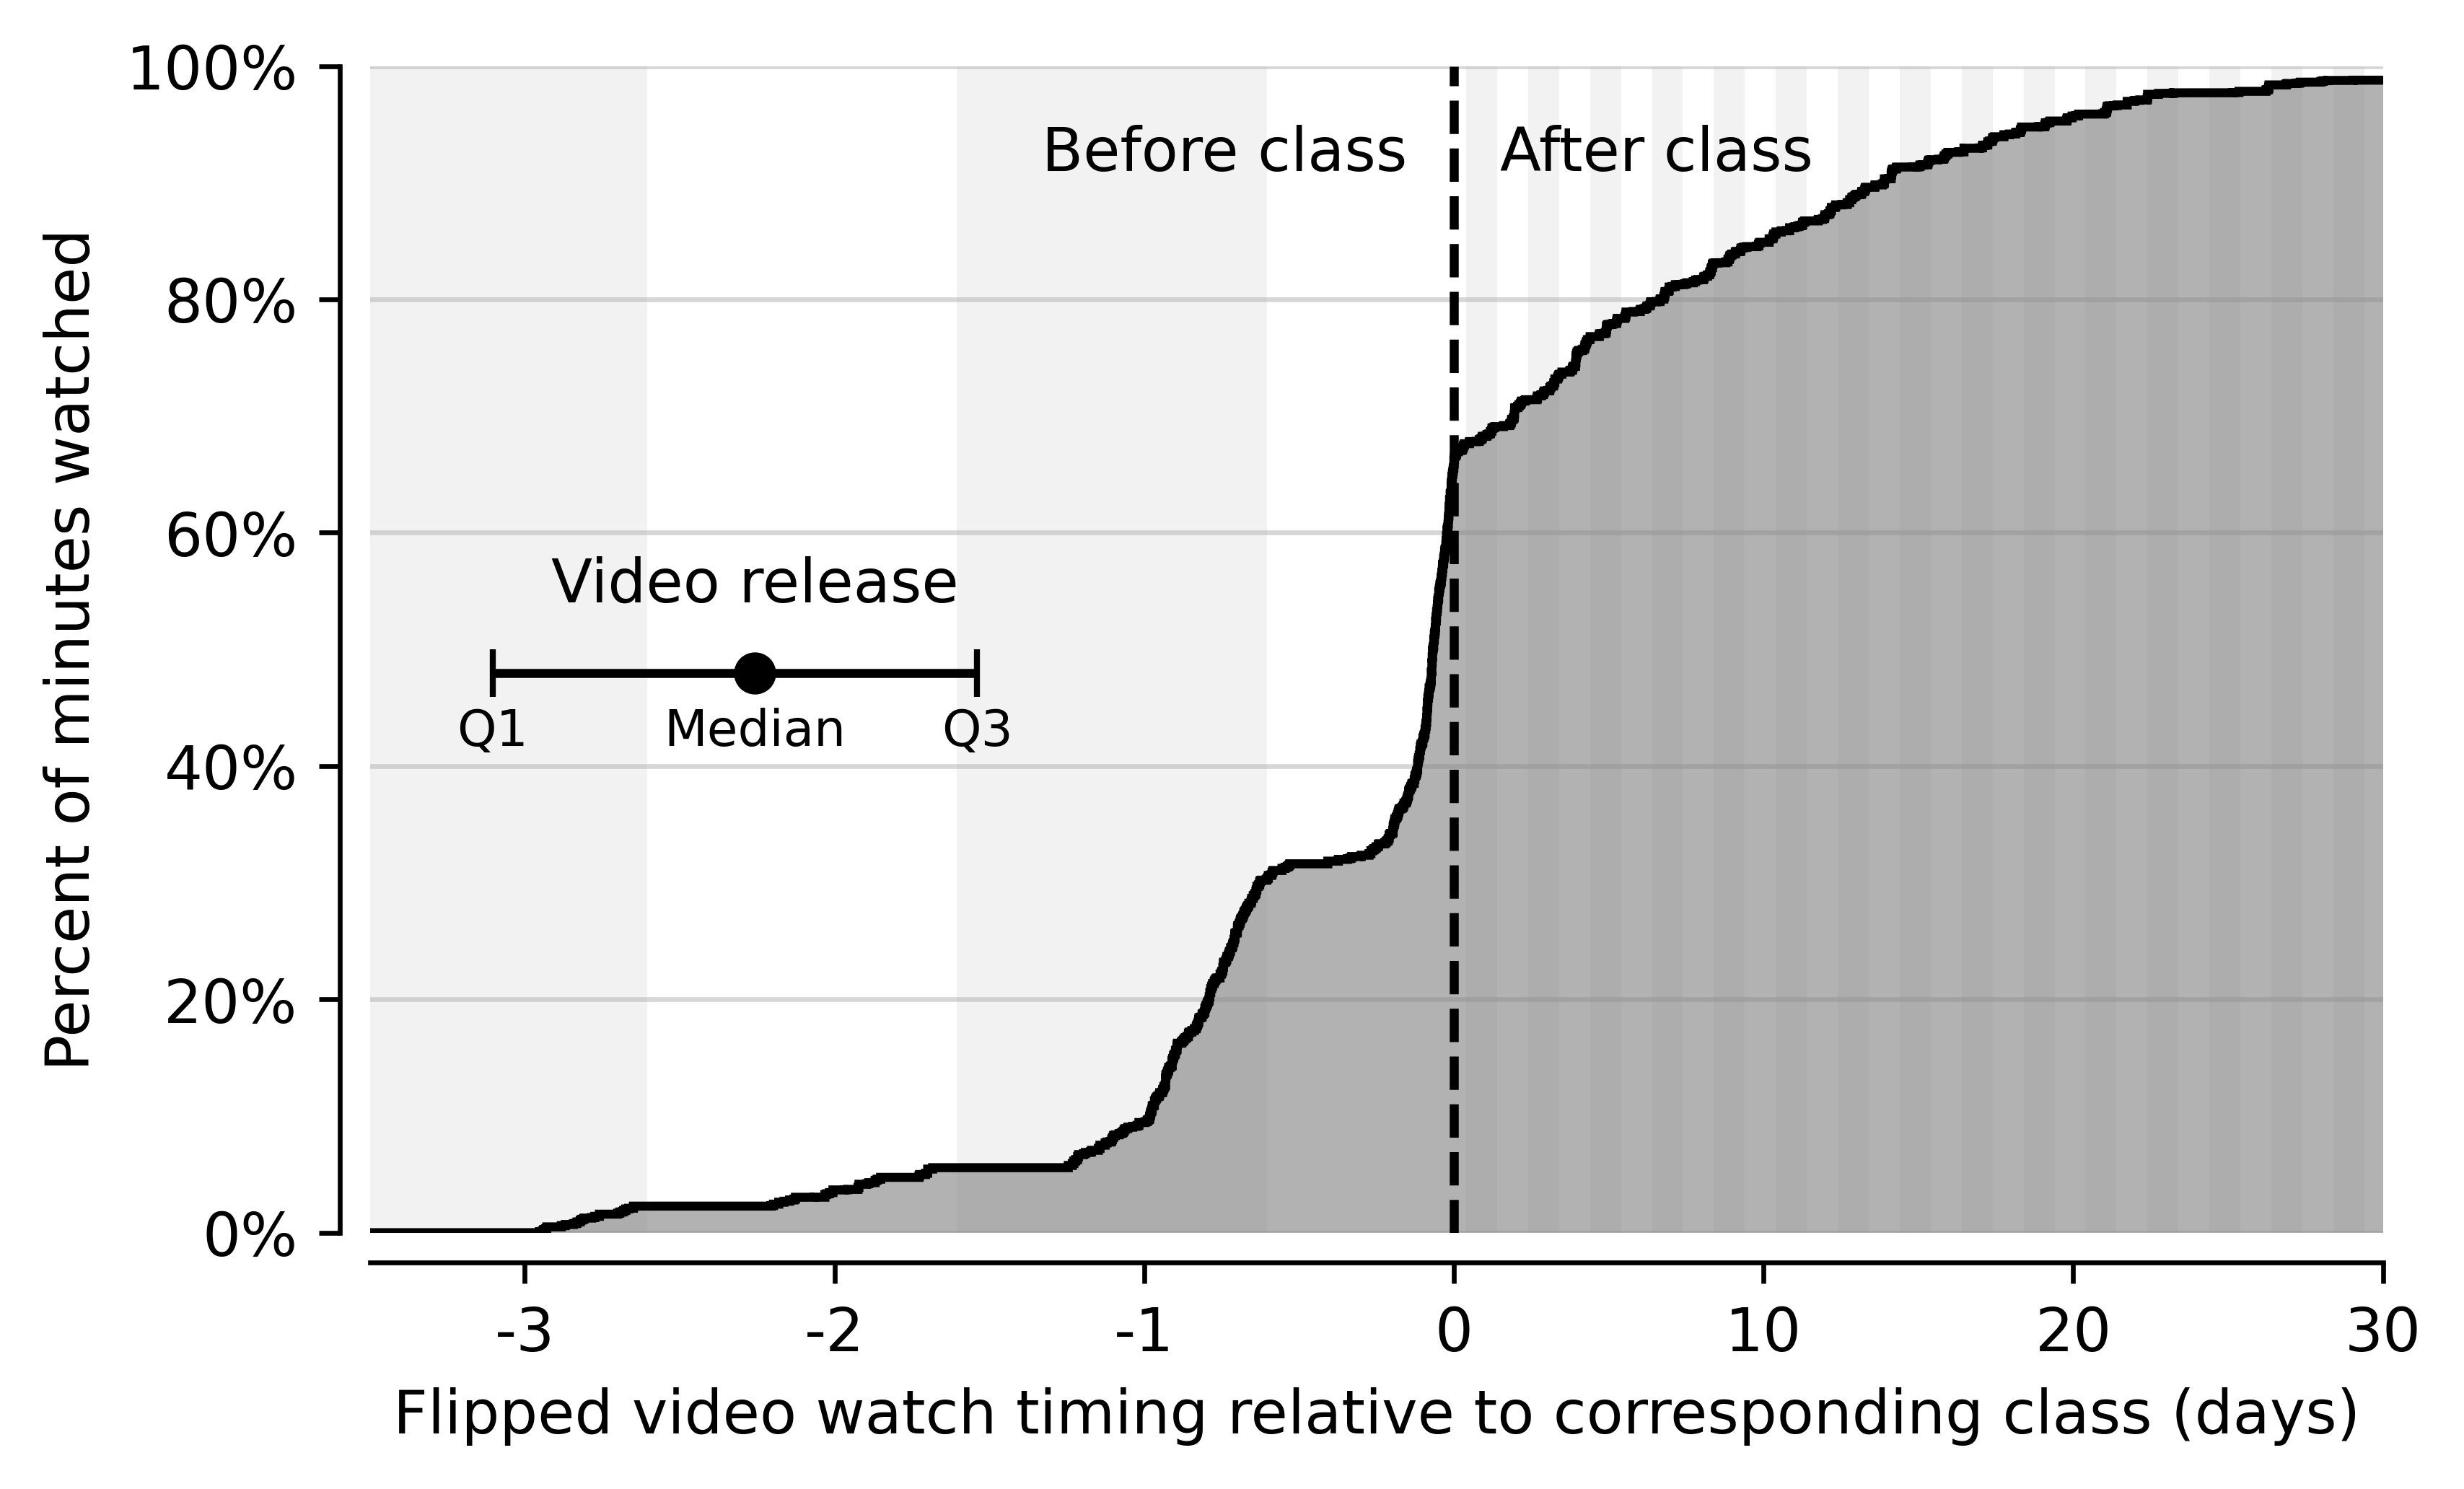

In [ ]:
# Cumulative distribution of Panopto video watch timing

# Compress positive region of x-axis by factor of 10
watch_timing_compressed_after = panopto_session_df['Watch timing relative to due date'] / timedelta(days=1)
watch_timing_compressed_after[watch_timing_compressed_after > 0] /= 10

# Make plot
plt.figure(figsize=(6,3.5),facecolor='w',dpi=600)
plt.hist(watch_timing_compressed_after,
         bins=np.arange(-4,3.1,0.001),
         weights=panopto_session_df['Minutes Delivered'] / np.sum(panopto_session_df['Minutes Delivered']),
         color='0.5',histtype='stepfilled',cumulative=True,alpha=0.6,zorder=3);
plt.hist(watch_timing_compressed_after,
         bins=np.arange(-4,3.1,0.001),
         weights=panopto_session_df['Minutes Delivered'] / np.sum(panopto_session_df['Minutes Delivered']),
         color='k',histtype='step',linewidth=1.5,cumulative=True,zorder=4);
plt.xlim([-3.5,3])
plt.ylim([0,1])
correct_xtick_labels = plt.xticks()[0]
correct_xtick_labels[correct_xtick_labels > 0] *= 10
plt.gca().set_xticklabels([str(int(val)) for val in correct_xtick_labels])
plt.gca().set_yticklabels(['{:.0f}%'.format(100*val) for val in plt.yticks()[0]])
plt.vlines(0,0,1,color='k',linewidth=1.5,linestyle='--',zorder=4)
for d in np.arange(-3,30,2):
  day_start = d+(-14.5/24)
  day_end = (d+1)+(-14.5/24)
  if day_start > 0: day_start /= 10
  if day_end > 0: day_end /= 10
  plt.axvspan(day_start,day_end,color='0.5',linewidth=0,alpha=0.1,zorder=1)
plt.grid(axis='y',alpha=0.5,zorder=1)
plt.ylabel('Percent of minutes watched')
plt.xlabel('Flipped video watch timing relative to corresponding class (days)')
# plt.title('Cumulative distribution of Panopto video watch timing\n($n$ = {0} videos; {1:.1f} total hours watched)\n'.format(len(panopto_info_df),np.sum(panopto_session_df['Minutes Delivered'])/60))
plt.text(-0.15,0.95,'Before class',horizontalalignment='right',verticalalignment='top')
plt.text(0.15,0.95,'After class',horizontalalignment='left',verticalalignment='top')

# Video release
plt.errorbar(release_median,0.48,xerr=np.array([[release_median-release_iqr25],[release_iqr75-release_median]]),
             marker='o',capsize=4,color='k')
plt.text(release_iqr25,0.45,'Q1',horizontalalignment='center',verticalalignment='top',fontsize='small')
plt.text(release_median,0.45,'Median',horizontalalignment='center',verticalalignment='top',fontsize='small')
plt.text(release_iqr75,0.45,'Q3',horizontalalignment='center',verticalalignment='top',fontsize='small')
plt.text(release_median,0.53,'Video release',horizontalalignment='center',verticalalignment='bottom')

# Formatting
plt.gca().spines['left'].set_position(('outward',5))
plt.gca().spines['bottom'].set_position(('outward',5))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig(export_to + 'Panopto watch timing.pdf',bbox_inches='tight')

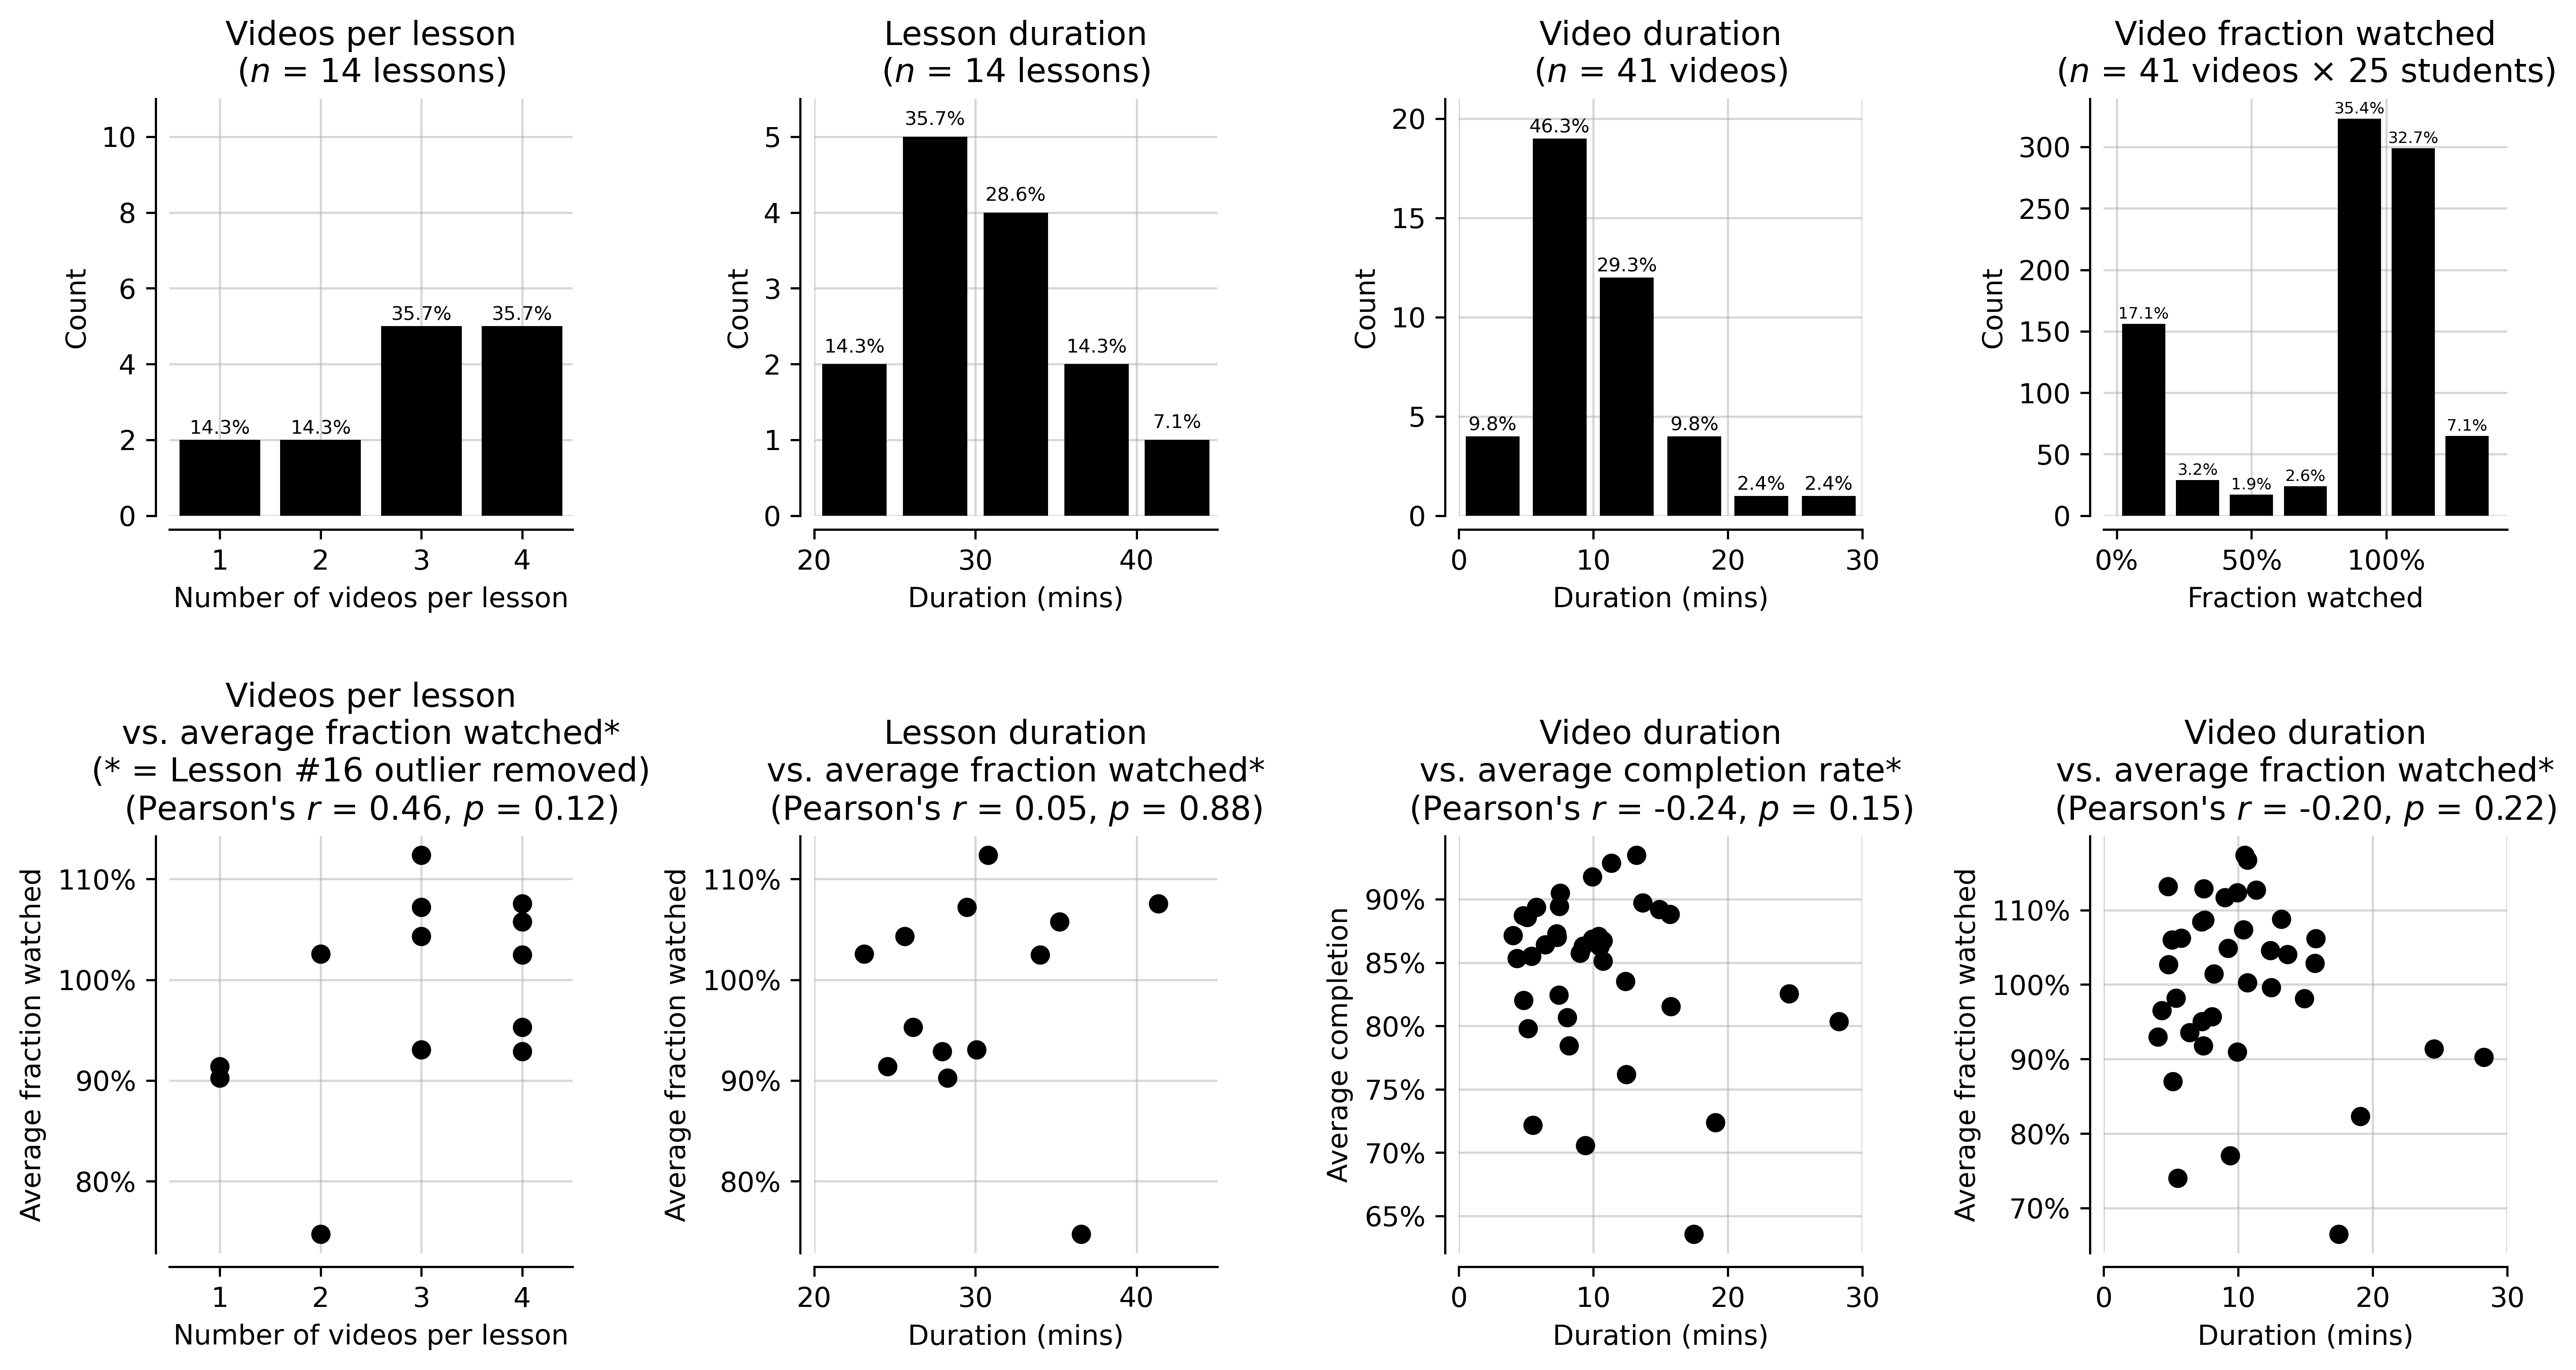

In [ ]:
# Panopto video duration vs. average completion rate
plt.figure(figsize=(13,7),facecolor='w',dpi=450)

def drop_spines():
  plt.gca().spines['left'].set_position(('outward',5))
  plt.gca().spines['bottom'].set_position(('outward',5))
  plt.gca().spines['top'].set_visible(False)
  plt.gca().spines['right'].set_visible(False)

plt.subplot(2,4,1)
hist = plt.hist(panopto_lesson_counts,bins=np.arange(-0.5,5+0.5,1),rwidth=0.8,color='k',zorder=2)
for y, x in zip(hist[0],hist[1]):
  if y != 0: plt.text(x+0.5,y+0.05,'{0:.1f}%'.format(100*y/np.sum(hist[0])),
                      horizontalalignment='center',verticalalignment='bottom',fontsize='x-small')
plt.xlim([0.5,4.5])
plt.xticks([1,2,3,4])
plt.ylim([0,11])
plt.xlabel('Number of videos per lesson')
plt.ylabel('Count')
plt.title('Videos per lesson\n($n$ = {0} lessons)'.format(len(panopto_lesson_durations)))
plt.grid(alpha=0.5,zorder=1)
drop_spines()

plt.subplot(2,4,2)
hist = plt.hist(panopto_lesson_durations,bins=np.arange(20,45+1,5),rwidth=0.8,color='k',zorder=2)
for y, x in zip(hist[0],hist[1]):
  if y != 0: plt.text(x+2.5,y+0.1,'{0:.1f}%'.format(100*y/np.sum(hist[0])),
                      horizontalalignment='center',verticalalignment='bottom',fontsize='x-small')
plt.xlim([20,45])
plt.ylim([0,5.5])
plt.xlabel('Duration (mins)')
plt.ylabel('Count')
plt.title('Lesson duration\n($n$ = {0} lessons)'.format(len(panopto_lesson_durations)))
plt.grid(alpha=0.5,zorder=1)
drop_spines()

plt.subplot(2,4,3)
hist = plt.hist(panopto_info_df['Duration (fractional minutes)'],bins=np.arange(0,30+1,5),rwidth=0.8,color='k',zorder=2)
for y, x in zip(hist[0],hist[1]):
  if y != 0: plt.text(x+2.5,y+0.1,'{0:.1f}%'.format(100*y/np.sum(hist[0])),
                      horizontalalignment='center',verticalalignment='bottom',fontsize='x-small')
plt.xlim([0,30])
plt.ylim([0,21])
plt.xlabel('Duration (mins)')
plt.ylabel('Count')
plt.title('Video duration\n($n$ = {0} videos)'.format(len(panopto_info_df)))
plt.grid(alpha=0.5,zorder=1)
drop_spines()

plt.subplot(2,4,4)
hist = plt.hist(100*(student_vs_video_delivery / panopto_info_df['Duration (fractional minutes)']).values.flatten(),
                bins=np.arange(0,150,20),rwidth=0.8,color='k',zorder=2)
for y, x in zip(hist[0],hist[1]):
  if y != 0: plt.text(x+10,y+2,'{0:.1f}%'.format(100*y/np.sum(hist[0])),
                      horizontalalignment='center',verticalalignment='bottom',fontsize='xx-small')
plt.xlabel('Fraction watched')
plt.ylabel('Count')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Video fraction watched\n' + r'($n$ = {0} videos $\times$ {1} students)'.format(len(panopto_info_df),len(all_ids)))
plt.grid(alpha=0.5,zorder=1)
drop_spines()

plt.subplot(2,4,5)
pearson_r, pearson_p = stats.pearsonr(panopto_lesson_counts.iloc[:-1],lesson_percent_delivery.iloc[:-1])
plt.scatter(panopto_lesson_counts.iloc[:-1],lesson_percent_delivery.iloc[:-1],c='k',zorder=2)
plt.xlim([0.5,4.5])
plt.xlabel('Number of videos per lesson')
plt.ylabel('Average fraction watched')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
plt.title('Videos per lesson\nvs. average fraction watched*\n(* = Lesson #16 outlier removed)\n' +
          '(Pearson\'s ' + r'$r$ = {0:.02f}, $p$ = {1:.02f})'.format(pearson_r,pearson_p))
plt.grid(alpha=0.5,zorder=1)
drop_spines()

plt.subplot(2,4,6)
pearson_r, pearson_p = stats.pearsonr(panopto_lesson_durations.iloc[:-1],lesson_percent_delivery.iloc[:-1])
plt.scatter(panopto_lesson_durations.iloc[:-1],lesson_percent_delivery.iloc[:-1],c='k',zorder=2)
plt.xlim([20,45])
plt.xlabel('Duration (mins)')
plt.ylabel('Average fraction watched')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
plt.title('Lesson duration\nvs. average fraction watched*\n' +
          '(Pearson\'s ' + r'$r$ = {0:.02f}, $p$ = {1:.02f})'.format(pearson_r,pearson_p))
plt.grid(alpha=0.5,zorder=1)
drop_spines()

plt.subplot(2,4,7)
pearson_r, pearson_p = stats.pearsonr(panopto_info_df['Duration (fractional minutes)'][:-3],
                                      student_vs_video_completion.mean(axis=0)[:-3])
plt.scatter(panopto_info_df['Duration (fractional minutes)'][:-3],
            student_vs_video_completion.mean(axis=0)[:-3],
            c='k',zorder=2)
plt.xlim([0,30])
plt.xlabel('Duration (mins)')
plt.ylabel('Average completion')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
plt.title('Video duration\nvs. average completion rate*\n' +
          '(Pearson\'s ' + r'$r$ = {0:.02f}, $p$ = {1:.02f})'.format(pearson_r,pearson_p))
plt.grid(alpha=0.5,zorder=1)
drop_spines()

plt.subplot(2,4,8)
pearson_r, pearson_p = stats.pearsonr(panopto_info_df['Duration (fractional minutes)'][:-3],
                                      video_percent_delivery[:-3])
plt.scatter(panopto_info_df['Duration (fractional minutes)'][:-3],
            video_percent_delivery[:-3],
            c='k',zorder=2)
plt.xlim([0,30])
plt.xlabel('Duration (mins)')
plt.ylabel('Average fraction watched')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
plt.title('Video duration\nvs. average fraction watched*\n' +
          '(Pearson\'s ' + r'$r$ = {0:.02f}, $p$ = {1:.02f})'.format(pearson_r,pearson_p))
plt.grid(alpha=0.5,zorder=1)
drop_spines()

plt.tight_layout(h_pad=2.5)
plt.savefig(export_to + 'Panopto statistics.pdf',bbox_inches='tight')

### Final projects (Fig. 7)

In [ ]:
# Aggregate final project cognitive level ratings
cog_questions = main_df[['Final project - cognitive level - question #1',
                         'Final project - cognitive level - question #2',
                         'Final project - cognitive level - question #3']]
cog_hypotheses = main_df[['Final project - cognitive level - hypothesis #1',
                          'Final project - cognitive level - hypothesis #2',
                          'Final project - cognitive level - hypothesis #3']]
cog_questions_weight = 1 / cog_questions.count(axis=1)
cog_hypotheses_weight = 1 / cog_hypotheses.count(axis=1)
cog_questions_all = cog_questions.values.T.flatten()[~np.isnan(cog_questions.values.T.flatten())]
cog_hypotheses_all = cog_hypotheses.values.T.flatten()[~np.isnan(cog_hypotheses.values.T.flatten())]
cog_questions_weight_all = np.tile(cog_questions_weight,3)[~np.isnan(cog_questions.values.T.flatten())]
cog_hypotheses_weight_all = np.tile(cog_hypotheses_weight,3)[~np.isnan(cog_hypotheses.values.T.flatten())]

# Combined cognitive level rating (= average of the average rating of questions and the average rating of hypotheses)
combined_cognitive_level = (cog_questions.mean(axis=1,skipna=True) + cog_hypotheses.mean(axis=1,skipna=True)) / 2

# Compare hypotheses to questions by student
hypothesis_question_diff = (cog_hypotheses.mean(axis=1,skipna=True) - cog_questions.mean(axis=1,skipna=True))

# Final project code analyses
code_syntax_used = main_df['Final project - code - percent of syntax used']
code_fig_count = main_df['Final project - code - figure count']
code_subplot_count = main_df['Final project - code - subplot count']
code_total_fig_count = code_fig_count + code_subplot_count

# Aggregate final project complexity ratings
project_domains = main_df[['Final project - complexity - physical','Final project - complexity - biological',
                           'Final project - complexity - chemical','Final project - complexity - geological',
                           'Final project - complexity - cryosphere','Final project - complexity - atmospheric']]
project_domains_sum_by_domain = project_domains.divide(project_domains.sum(axis=1),axis='index').sum(axis=0)
project_domains_sum_by_student = project_domains.sum(axis=1)
project_file_types_sum_by_student = main_df[['Final project - complexity - CSV','Final project - complexity - NetCDF']].sum(axis=1)
project_datasets = main_df['Final project - complexity - number of datasets']

# Combined complexity rating (= sum of # project domains, # file types, and # data sets used)
combined_complexity = project_domains_sum_by_student + project_file_types_sum_by_student + project_datasets

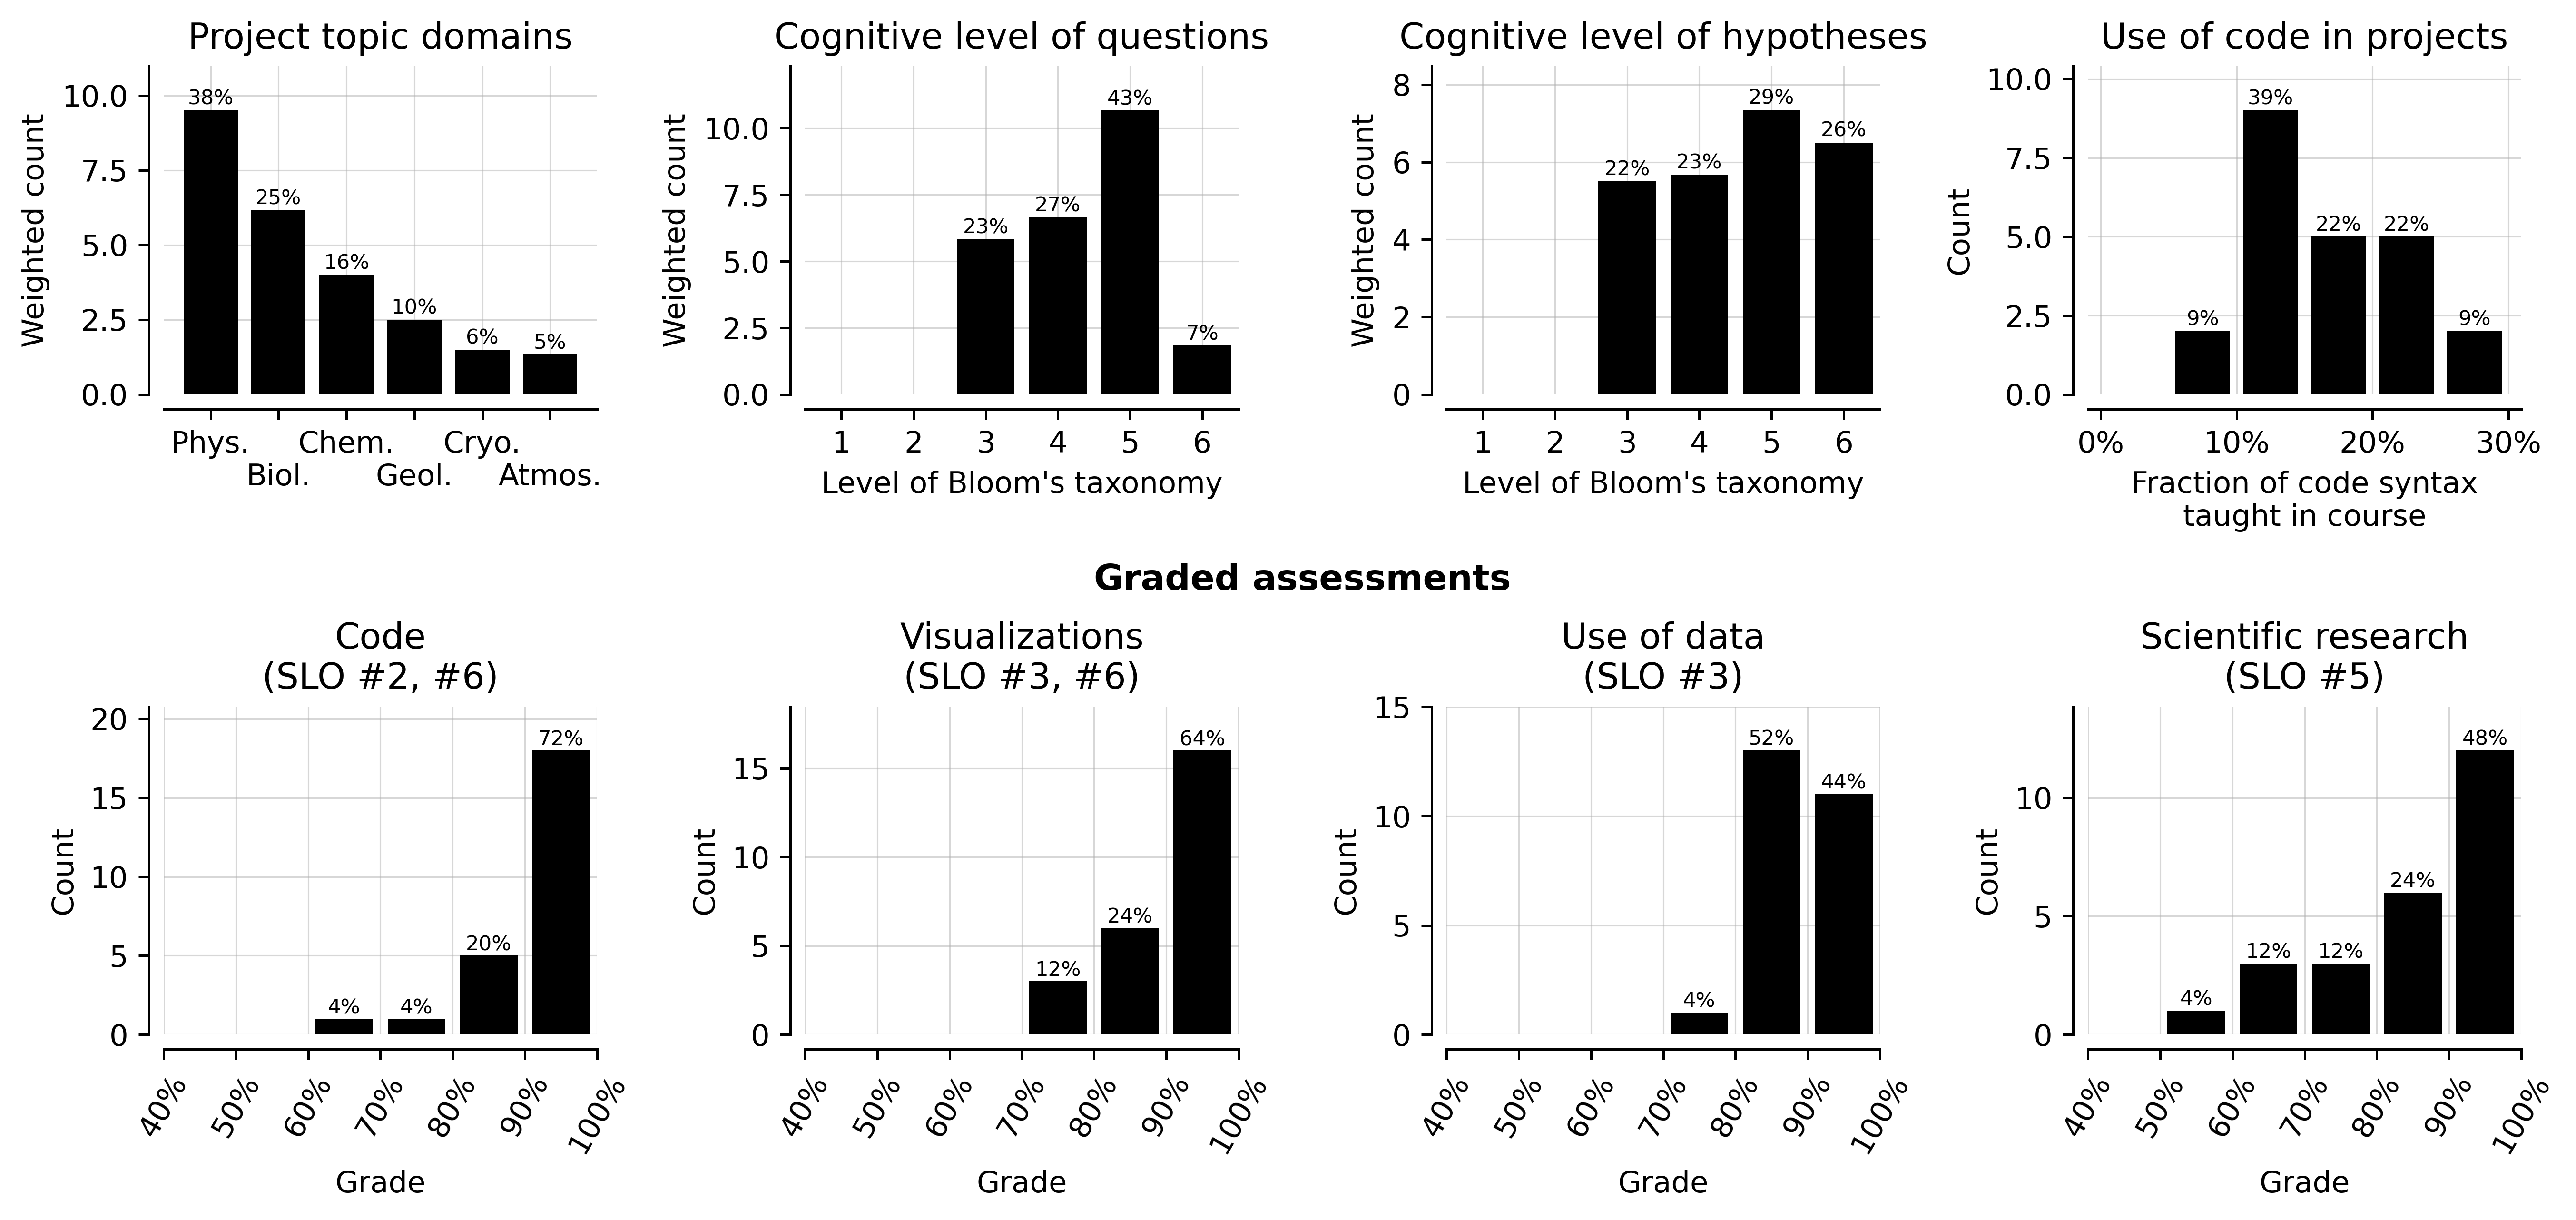

In [ ]:
# Plot summary of final project metrics
def drop_spines():
  plt.gca().spines['left'].set_position(('outward',5))
  plt.gca().spines['bottom'].set_position(('outward',5))
  plt.gca().spines['top'].set_visible(False)
  plt.gca().spines['right'].set_visible(False)

plt.figure(figsize=(12,6.5),facecolor='w',dpi=450)

plt.subplot(2,4,1)
plt.bar(range(len(project_domains_sum_by_domain)),project_domains_sum_by_domain.values,
        tick_label=['Phys.','\nBiol.','Chem.','\nGeol.','Cryo.','\nAtmos.'],
        width=0.8,color='k',zorder=2)
for y, x in zip(project_domains_sum_by_domain.values,range(len(project_domains_sum_by_domain))):
  if y != 0: plt.text(x,y+0.05,'{0:.0f}%'.format(100*y/np.sum(project_domains_sum_by_domain.values)),
                      horizontalalignment='center',verticalalignment='bottom',fontsize='x-small')
plt.ylim([None,plt.ylim()[1]*1.1])
plt.setp(plt.gca().get_xticklabels(),ha="right",rotation=45)
plt.title('Project topic domains')
plt.ylabel('Weighted count')
plt.grid(alpha=0.5,lw=0.5,zorder=1)
drop_spines()

plt.subplot(2,4,2)
hist = plt.hist(cog_questions_all,weights=cog_questions_weight_all,bins=np.arange(2.5,7,1),rwidth=0.8,color='k',zorder=2)
for y, x in zip(hist[0],hist[1]):
  if y != 0: plt.text(x+0.5,y+0.05,'{0:.0f}%'.format(100*y/np.sum(hist[0])),
                      horizontalalignment='center',verticalalignment='bottom',fontsize='x-small')
plt.xlim(0.5,6.5)
plt.xticks([1,2,3,4,5,6])
plt.ylim([None,plt.ylim()[1]*1.1])
plt.title('Cognitive level of questions')
plt.xlabel("Level of Bloom's taxonomy")
plt.ylabel('Weighted count')
plt.grid(alpha=0.5,lw=0.5,zorder=1)
drop_spines()

plt.subplot(2,4,3)
hist = plt.hist(cog_hypotheses_all,weights=cog_hypotheses_weight_all,bins=np.arange(2.5,7,1),rwidth=0.8,color='k',zorder=2)
for y, x in zip(hist[0],hist[1]):
  if y != 0: plt.text(x+0.5,y+0.05,'{0:.0f}%'.format(100*y/np.sum(hist[0])),
                      horizontalalignment='center',verticalalignment='bottom',fontsize='x-small')
plt.xlim(0.5,6.5)
plt.xticks([1,2,3,4,5,6])
plt.ylim([None,plt.ylim()[1]*1.1])
plt.title('Cognitive level of hypotheses')
plt.xlabel("Level of Bloom's taxonomy")
plt.ylabel('Weighted count')
plt.grid(alpha=0.5,lw=0.5,zorder=1)
drop_spines()

plt.subplot(2,4,4)
values_for_hist = main_df['Final project - code - percent of syntax used'].dropna().values
hist = plt.hist(values_for_hist,bins=np.arange(0,values_for_hist.max()+5,5),rwidth=0.8,color='k',zorder=2)
for y, x in zip(hist[0],hist[1]):
  if y != 0: plt.text(x+2.5,y+0.05,'{0:.0f}%'.format(100*y/np.sum(hist[0])),
                      horizontalalignment='center',verticalalignment='bottom',fontsize='x-small')
plt.ylim([None,plt.ylim()[1]*1.1])
plt.title("Use of code in projects")
plt.xlabel("Fraction of code syntax\ntaught in course")
plt.ylabel('Count')
plt.grid(alpha=0.5,lw=0.5,zorder=1)
drop_spines()
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

plt.suptitle('Graded assessments',y=0.48,weight='bold')

plt.subplot(2,4,5)
values_for_hist = (main_df['Grade - final project - code - correctness (out of 8)'] +
                   main_df['Grade - final project - code - functionality (out of 5)'] +
                   main_df['Grade - final project - code - tidiness (out of 6)'] +
                   main_df['Grade - final project - code - perseverance (out of 5)']).dropna().values / 24
hist = plt.hist(100*values_for_hist,bins=np.arange(0,100+10,10),rwidth=0.8,color='k',zorder=2)
for y, x in zip(hist[0],hist[1]):
  if y != 0: plt.text(x+5,y+0.05,'{0:.0f}%'.format(100*y/np.sum(hist[0])),
                      horizontalalignment='center',verticalalignment='bottom',fontsize='x-small')
plt.ylim([None,plt.ylim()[1]*1.1])
plt.title('Code\n(SLO #2, #6)')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.grid(alpha=0.5,lw=0.5,zorder=1)
drop_spines()
plt.xlim([40,100])
plt.xticks(np.arange(40,100+10,10),rotation=60)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())

plt.subplot(2,4,6)
values_for_hist = (main_df['Grade - final project - plots - clarity (out of 5)'] +
                   main_df['Grade - final project - plots - colormaps (out of 3)'] +
                   main_df['Grade - final project - plots - labels (out of 5)'] +
                   main_df['Grade - final project - plots - creativity (out of 3)']).dropna().values / 16
hist = plt.hist(100*values_for_hist,bins=np.arange(0,100+10,10),rwidth=0.8,color='k',zorder=2)
for y, x in zip(hist[0],hist[1]):
  if y != 0: plt.text(x+5,y+0.05,'{0:.0f}%'.format(100*y/np.sum(hist[0])),
                      horizontalalignment='center',verticalalignment='bottom',fontsize='x-small')
plt.ylim([None,plt.ylim()[1]*1.1])
plt.title('Visualizations\n(SLO #3, #6)')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.grid(alpha=0.5,lw=0.5,zorder=1)
drop_spines()
plt.xlim([40,100])
plt.xticks(np.arange(40,100+10,10),rotation=60)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())

plt.subplot(2,4,7)
values_for_hist = (main_df['Grade - final project - presentation - data information (out of 3)'] +
                   main_df['Grade - final project - presentation - data processing (out of 3)'] +
                   main_df['Grade - final project - presentation - results (out of 3)']).dropna().values / 9
hist = plt.hist(100*values_for_hist,bins=np.arange(0,100+10,10),rwidth=0.8,color='k',zorder=2)
for y, x in zip(hist[0],hist[1]):
  if y != 0: plt.text(x+5,y+0.05,'{0:.0f}%'.format(100*y/np.sum(hist[0])),
                      horizontalalignment='center',verticalalignment='bottom',fontsize='x-small')
plt.ylim([None,plt.ylim()[1]*1.1])
plt.title('Use of data\n(SLO #3)')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.grid(alpha=0.5,lw=0.5,zorder=1)
drop_spines()
plt.xlim([40,100])
plt.xticks(np.arange(40,100+10,10),rotation=60)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())

plt.subplot(2,4,8)
values_for_hist = (main_df['Grade - final project - presentation - background (out of 3)'] +
                   main_df['Grade - final project - presentation - questions/hypotheses (out of 2)'] +
                   main_df['Grade - final project - presentation skills - explanations (out of 3)']).dropna().values / 8
hist = plt.hist(100*values_for_hist,bins=np.arange(0,100+10,10),rwidth=0.8,color='k',zorder=2)
for y, x in zip(hist[0],hist[1]):
  if y != 0: plt.text(x+5,y+0.05,'{0:.0f}%'.format(100*y/np.sum(hist[0])),
                      horizontalalignment='center',verticalalignment='bottom',fontsize='x-small')
plt.ylim([None,plt.ylim()[1]*1.1])
plt.title('Scientific research\n(SLO #5)')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.grid(alpha=0.5,lw=0.5,zorder=1)
drop_spines()
plt.xlim([40,100])
plt.xticks(np.arange(40,100+10,10),rotation=60)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())

plt.tight_layout(rect=[0,0,1,0.94],h_pad=3)

plt.savefig(export_to + 'Final projects_revised.pdf',bbox_inches='tight')

In [ ]:
# Range of code usage metric
print(main_df['Final project - code - percent of syntax used'].min(),
      main_df['Final project - code - percent of syntax used'].max())

5.714285714 29.28571429


In [ ]:
# Test for possible relationship between questions/hypotheses' cognitive level vs. code usage
temp_mask = np.isnan(main_df['Final project - code - percent of syntax used'])
pearson_r, pearson_p = stats.pearsonr(cog_questions.mean(axis=1)[~temp_mask],main_df['Final project - code - percent of syntax used'][~temp_mask])
print('p-value for final project question average cognitive level vs. code usage:',pearson_p)
pearson_r, pearson_p = stats.pearsonr(cog_hypotheses.mean(axis=1)[~temp_mask],main_df['Final project - code - percent of syntax used'][~temp_mask])
print('p-value for final project hypotheses average cognitive level vs. code usage:',pearson_p)

p-value for final project question average cognitive level vs. code usage: 0.7273064642345082
p-value for final project hypotheses average cognitive level vs. code usage: 0.405435579526286


### Student metric correlations (Fig. 6)

In [ ]:
# Metric storage
metrics = pd.DataFrame(index=all_ids).sort_index()
units_dict = {}
metrics_small_version = pd.DataFrame(index=all_ids).sort_index()
units_dict_small_version = {}
metrics_small_version_labels = []

# Aggregator function
def save_metric(name,units,series,keep_for_small_version=True):
  name_without_line_break = name.replace('\n',' ')
  metrics[name_without_line_break] = series.copy()
  units_dict[name_without_line_break] = units
  if keep_for_small_version:
    metrics_small_version[name_without_line_break] = series.copy()
    units_dict_small_version[name_without_line_break] = units
    metrics_small_version_labels.append(name)

### Metrics by student:

# Final course grade, expressed as difference from average class grade
# (excluding two students with missing Assignment #2; their final grades are listed as NaN)
grades = main_df['Grade - final grade (out of 100)'].sort_index().copy()
save_metric('Final grade (not re-calculated)','%',
            grades - grades.mean(),
            keep_for_small_version=False)

# Final course grade, expressed as difference from average class grade
# (including two students with missing Assignment #2; their grades are recalculated excluding A#2)
a0_grades = main_df['Grade - Assignment #0 (out of 50)'].copy()
a1_grades = main_df['Grade - Assignment #1 (out of 50)'].copy()
a2_grades = main_df['Grade - Assignment #2 (out of 50)'].copy()
a3_grades = main_df['Grade - Assignment #3 (out of 50)'].copy()
a4_grades = main_df['Grade - Assignment #4 (out of 50)'].copy()
a2_grades[a2_grades == 0] = np.NaN
assignment_grades = pd.DataFrame([a0_grades,a1_grades,a2_grades,a3_grades,a4_grades]).mean(axis=0).sort_index()
students_to_recalc = main_df.index[main_df['Grade - Assignment #2 (out of 50)'] == 0].values
grades_recalc = grades.copy()
for id in students_to_recalc:
  recalc_final_grade = 0.6 * 100 * assignment_grades.loc[id] / 50 + \
                       0.25 * main_df['Grade - final project total (out of 100)'].loc[id] + \
                       0.15 * main_df['Grade - Piazza total (out of 100)'].loc[id]
  grades_recalc.loc[id] = recalc_final_grade
print('Statistics on final grades, before re-calculating:')
print('Mean: ',grades.mean())
print('Standard deviation: ',grades.std())
print('Statistics on final grades, after re-calculating:')
print('Mean: ',grades_recalc.mean())
print('Standard deviation: ',grades_recalc.std())
save_metric('Final grade','%',
            grades_recalc - grades_recalc.mean(),
            keep_for_small_version=True)

# Average assignment grade, expressed as difference from average class grade
# (note: A#0-A#4; excluded zero scores when calculating average)
save_metric('Average assignment grade (1-4 only)','%',
            100 * (assignment_grades - assignment_grades.mean()) / 50,
            keep_for_small_version=False)

# Final project grade, expressed as difference from average class grade
save_metric('Project grade','%',
            main_df['Grade - final project total (out of 100)'].sort_index() - main_df['Grade - final project total (out of 100)'].mean(),
            keep_for_small_version=False)

# Final project code and plots grade, expressed as difference from average class grade
save_metric('Project grade (code and plots only)','%',
            100 * (main_df['Grade - final project code and plots (out of 40)'].sort_index() - main_df['Grade - final project code and plots (out of 40)'].mean()) / 40,
            keep_for_small_version=False)

# Final project combined cognitive level (averaged ratings of questions and hypotheses using Bloom's taxonomy)
save_metric('Project cognitive level',None,
            combined_cognitive_level.sort_index(),
            keep_for_small_version=False)

# Final project combined complexity (sum of # of domains, # of file types, and # of data sets)
save_metric('Project complexity',None,
            combined_complexity.sort_index(),
            keep_for_small_version=False)

# Final project combined challenge score (average of cognitive level and complexity)
save_metric('Project challenge score',None,
            ((combined_cognitive_level + combined_complexity) / 2).sort_index(),
            keep_for_small_version=False)

# Final project syntax used (percent of keywords [functions, operators, methods] taught that were present in students' code notebooks)
save_metric('Python skills\nused in project',None,
            code_syntax_used.sort_index(),
            keep_for_small_version=True)

# Final project number of figures identified in code
save_metric('Project figure count',None,
            code_total_fig_count.sort_index(),
            keep_for_small_version=False)

# Number of pair programming experiences
# (incl. A#2-A#4, final project; minimum is 0, maximum is 4)
percent_collaborated = (main_df[['Assignment #2 - partner pair ID','Assignment #3 - partner pair ID',
                                 'Assignment #4 - partner pair ID','Final project - partner pair ID']].count(axis=1) >= 1).mean()
print('\nStatistics on collaboration:')
print('Fraction of class that exercised pair programming option on an assignment or project:',100*percent_collaborated,'%')
average_percent_pair = main_df[['Assignment #2 - partner pair ID','Assignment #3 - partner pair ID',
                                'Assignment #4 - partner pair ID','Final project - partner pair ID']].notna().mean(axis=0).mean()
print('Average fraction of students collaborating on any given assignment or project:',100*average_percent_pair,'%')
save_metric('Pair programming\nexperiences',None,
            main_df[['Assignment #2 - partner pair ID','Assignment #3 - partner pair ID',
                     'Assignment #4 - partner pair ID','Final project - partner pair ID']].count(axis=1).sort_index(),
            keep_for_small_version=True)

# Piazza days online
save_metric('Q&A forum days online','days',
            main_df['Piazza - days online'].sort_index(),
            keep_for_small_version=True)

# Piazza views
save_metric('Q&A forum views',None,
            main_df['Piazza - views'].sort_index(),
            keep_for_small_version=False)

# Piazza total contributions (questions, notes, answers, and comments)
save_metric('Q&A forum total contributions',None,
            main_df['Piazza - contributions'].sort_index(),
            keep_for_small_version=True)

# Piazza questions and notes
save_metric('Q&A forum questions and notes',None,
            (main_df['Piazza - questions'] + main_df['Piazza - notes']).sort_index(),
            keep_for_small_version=False)

# Piazza answers
save_metric('Q&A forum answers only',None,
            main_df['Piazza - answers'].sort_index(),
            keep_for_small_version=True)

# Panopto total video views
save_metric('Total flipped video views',None,
            main_df['Panopto - views and downloads'].sort_index(),
            keep_for_small_version=False)

# Panopto average video delivery fraction (which can be > 100%)
save_metric('Average video delivery','%',
            100*(student_vs_video_delivery / panopto_info_df['Duration (fractional minutes)']).mean(axis=1),
            keep_for_small_version=False)

# Panopto total video minutes delivered
save_metric('Video minutes watched',None,
            main_df['Panopto - minutes delivered'].sort_index(),
            keep_for_small_version=True)

# Fraction of total minutes watched on Panopto before class
save_metric('Fraction of total video minutes watched before class','%',
            100 * total_lesson_minutes_delivered_before_class / (total_lesson_minutes_delivered_before_class + total_lesson_minutes_delivered_after_class),
            keep_for_small_version=False)

# Panopto average watch timing relative to class date, weighted by minutes viewed
watch_timing_weighted = panopto_session_df.groupby('ID No.').apply(lambda x: np.average(x['Watch timing relative to due date'] / timedelta(days=-1),
                                                                                        weights=x['Minutes Delivered']))
save_metric('Average video watch timing relative to class','days before class',
            watch_timing_weighted,
            keep_for_small_version=False)

# Minutes watched on Panopto before class
save_metric('Video minutes watched\nbefore class','mins',
            total_lesson_minutes_delivered_before_class,
            keep_for_small_version=True)

# Minutes watched on Panopto after class for first time
save_metric('Video minutes watched\nafter class (for first time)','mins',
            total_lesson_minutes_delivered_after_class - total_lesson_minutes_delivered_after_class_rewatches,
            keep_for_small_version=True)

# Minutes watched on Panopto after class that were 're-watches'
save_metric("Video minutes watched\nafter class (re-watched)",'mins',
            total_lesson_minutes_delivered_after_class_rewatches,
            keep_for_small_version=False)

# Panopto average watch timing before class date only, weighted by minutes viewed
# (same as above, but only for views before class)
only_views_before_class = panopto_session_df[panopto_session_df['Watch timing relative to due date'] / timedelta(days=1) <= 0]
watch_timing_weighted_before_class = only_views_before_class.groupby('ID No.').apply(lambda x: np.average(x['Watch timing relative to due date'] / timedelta(days=-1),
                                                                                                          weights=x['Minutes Delivered']))
save_metric('Video watch timing\n(before class only)','days before class',
            watch_timing_weighted_before_class,
            keep_for_small_version=False)

# Fraction of total minutes watched on Panopto before class
save_metric('Fraction of total video minutes watched before class','%',
            100 * total_lesson_minutes_delivered_before_class / (total_lesson_minutes_delivered_before_class + total_lesson_minutes_delivered_after_class),
            keep_for_small_version=False)

# Panopto average watch timing relative to class date, weighted by minutes viewed
watch_timing_weighted = panopto_session_df.groupby('ID No.').apply(lambda x: np.average(x['Watch timing relative to due date'] / timedelta(days=-1),
                                                                                        weights=x['Minutes Delivered']))
save_metric('Average video watch timing relative to class','days before class',
            watch_timing_weighted,
            keep_for_small_version=False)

# Panopto average views per video on distinct days
average_views_per_video = panopto_session_df.groupby('ID No.').apply(lambda x: x.groupby('Session Name').apply(lambda y: len(np.unique(y['Timestamp'].dt.date))).mean())
save_metric('Average views per video on distinct days',None,
            average_views_per_video,
            keep_for_small_version=False)

# Prior coding experience (aggregate of Assignment #0 with updated rubric and PollEverywhere self-assessment)
experience_pollev_scaled = main_df['Class #0 PollEverywhere - prior coding experience, mapped to 0-3 scale'].sort_index() * (4/3)
experience_assign0_scaled = main_df['Assignment #0 - prior coding experience (out of 5; new version)'].sort_index() - 1
experience_aggregate = pd.DataFrame([experience_pollev_scaled,experience_assign0_scaled]).mean(skipna=True)
save_metric('Initial self-assessment of prior coding experience (aggregate)',None,
            experience_aggregate,
            keep_for_small_version=False)

# Prior coding experience (from Assignment #0 - updated rubric)
save_metric('Prior coding experience',None,
            main_df['Assignment #0 - prior coding experience (out of 5; new version)'].sort_index(),
            keep_for_small_version=True)

# Prior coding experience (from Assignment #0 - prelim rubric)
save_metric('Initial self-assessment of prior coding experience (old version)',None,
            main_df['Assignment #0 - prior coding experience (out of 5; old version)'].sort_index(),
            keep_for_small_version=False)

# Prior comfort with technology (from Assignment #0 - prelim rubric)
save_metric('Initial self-assessment of prior comfort with technology',None,
            main_df['Assignment #0 - comfort with technology (out of 5; old version)'].sort_index(),
            keep_for_small_version=False)

# End-of-course survey (average rating; 1-6)
# NOTE: data are missing from two students
save_metric('Final self-assessment (average of all questions)',None,
            main_df['Final survey - average rating'].sort_index(),
            keep_for_small_version=False)

# End-of-course survey - proficiency in Python (average rating; 1-6)
# NOTE: data are missing from two students
save_metric('Final self-assessment\nof Python skills',None,
            main_df['Final survey - proficiency in Python'].sort_index(),
            keep_for_small_version=True)

# End-of-course survey - comfort with technology (rating 1-6)
# NOTE: data are missing from two students
save_metric('Final self-assessment (comfort with technology only)',None,
            main_df['Final survey - comfort with technology'].sort_index(),
            keep_for_small_version=False)

Statistics on final grades, before re-calculating:
Mean:  95.0692
Standard deviation:  5.691471631602265
Statistics on final grades, after re-calculating:
Mean:  95.89795999999998
Standard deviation:  3.834526790448421

Statistics on collaboration:
Fraction of class that exercised pair programming option on an assignment or project: 48.0 %
Average fraction of students collaborating on any given assignment or project: 34.0 %


In [ ]:
# Construct correlation matrices using Pandas
# Mask out correlations without significance (p >= 0.05)
# NOTE: Pearson tests for linearity, and Spearman rank correlation tests for monotonicity
#       > Higher Pearson correlations indicate stronger positive linear relationships
#       > Higher Spearman’s ρ values indicate stronger monotonic relationships, though not necessarily linear

metrics_to_use = metrics_small_version   # use this to switch between <<metrics_small_version>> or <<metrics>>
corr_matrix_pearson = metrics_to_use.corr(method='pearson')
corr_matrix_spearman = metrics_to_use.corr(method='spearman')
for metric_name1 in metrics_to_use.keys():
  for metric_name2 in metrics_to_use.keys():
    pearson_r, pearson_p = stats.pearsonr(*[metrics_to_use[[metric_name1,metric_name2]].dropna().iloc[:,col].values for col in [0,1]])
    spearman_r, spearman_p = stats.spearmanr(*[metrics_to_use[[metric_name1,metric_name2]].dropna().iloc[:,col].values for col in [0,1]])
    if pearson_p >= 0.05: corr_matrix_pearson.loc[metric_name1][metric_name2] = np.NaN
    if spearman_p >= 0.05: corr_matrix_spearman.loc[metric_name1][metric_name2] = np.NaN

# Choose highest absolute value of two correlation methods
def abs_max(input0,input1):
  inputs = np.array([input0,input1])
  if np.isnan(inputs).all(): return np.nan
  else:                      return inputs[np.nanargmax(np.abs(inputs))]
vec_abs_max = np.vectorize(abs_max)
corr_matrix_max = corr_matrix_pearson.copy()
corr_matrix_max[:] = pd.DataFrame(vec_abs_max(corr_matrix_pearson,corr_matrix_spearman)).values

# Display correlation matrix
# (note: save using .render() to HTML, or .to_excel() to XSLX including conditional formatting)
corr_matrix_max.style.background_gradient(cmap='coolwarm',axis=None).set_precision(2)

# Output to HTML render
# corr_matrix_html = corr_matrix.style.background_gradient(cmap='coolwarm',axis=None).set_precision(2).render()
# corr_matrix_file = open('student_metric_correlation_matrix.html','w')
# corr_matrix_file.write(corr_matrix_html)
# corr_matrix_file.close()

# Export to Excel file
# corr_matrix.to_excel(filepath + 'Student metrics correlation matrix.xlsx')

<ipython-input-41-970cd6c69440>:28: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_matrix_max.style.background_gradient(cmap='coolwarm',axis=None).set_precision(2)


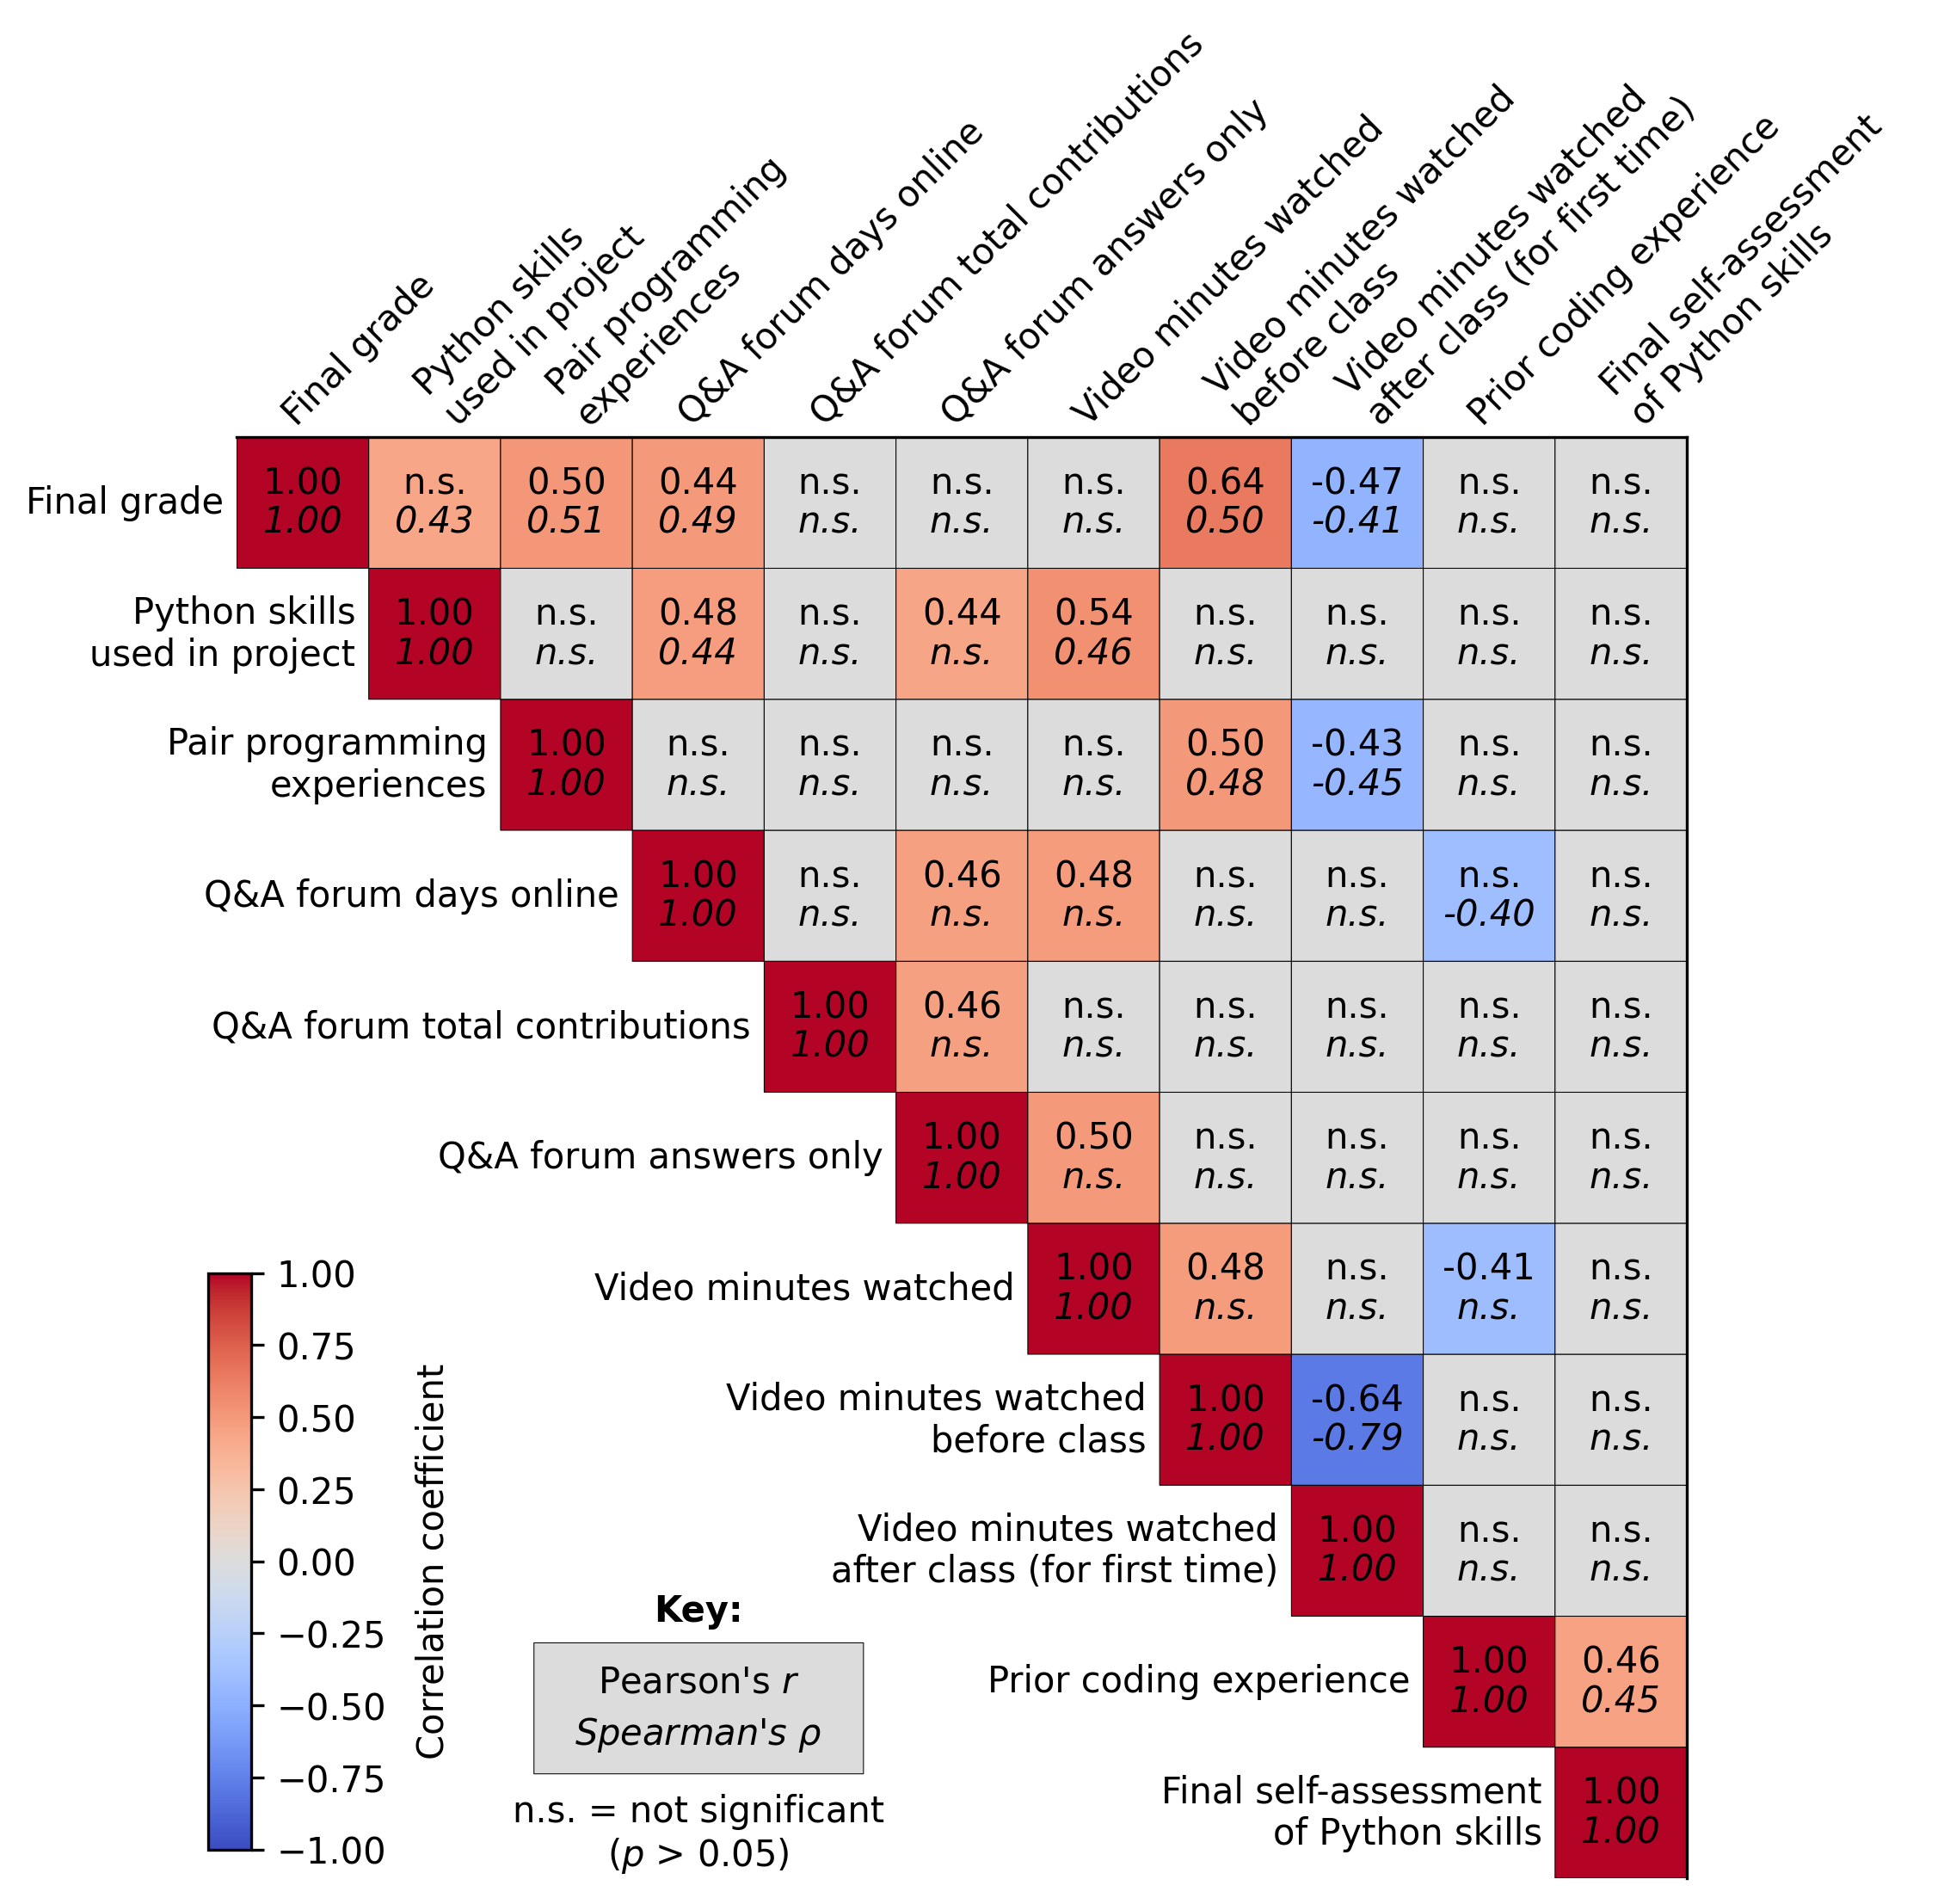

In [ ]:
# Pre-processing
corr_matrix_values = corr_matrix_max.values.copy()
corr_matrix_values[np.isnan(corr_matrix_values)] = 999.999    # set cells with NaN (no significant correlation) to 999.999, then 0.0, to display as white
corr_matrix_max_masked = np.ma.masked_array(corr_matrix_values,np.triu(corr_matrix_values) == 0)
corr_matrix_max_reorient = corr_matrix_max_masked[::-1,:]
corr_matrix_max_reorient[corr_matrix_max_reorient == 999.999] = 0.0

# Pre-processing (labels)
corr_matrix_pearson_reorient = corr_matrix_pearson.values.copy()[::-1,:]
corr_matrix_spearman_reorient = corr_matrix_spearman.values.copy()[::-1,:]

# Plot correlation matrix
plt.figure(figsize=(7.25,7.25),facecolor='w',dpi=300)
plt.pcolor(corr_matrix_max_reorient,cmap='coolwarm',edgecolors='k',vmin=-1.0,vmax=1.0)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
for m in range(len(metrics_small_version_labels)):
  plt.text(0.3+m,len(metrics_small_version_labels)+0.1,metrics_small_version_labels[m],
           rotation=45)
  plt.text(m-0.1,len(metrics_small_version_labels)-0.5-m,metrics_small_version_labels[m],
           verticalalignment='center',horizontalalignment='right')
for row_idx in np.arange(-1,-1*len(corr_matrix_pearson_reorient)-1,-1):
  for col_idx in np.arange(-1*row_idx - 1,len(corr_matrix_pearson_reorient)):
    pearson = corr_matrix_pearson_reorient[row_idx,col_idx]
    spearman = corr_matrix_spearman_reorient[row_idx,col_idx]
    if np.isnan(pearson): pearson_label = 'n.s.'
    else:                 pearson_label = '{0:.2f}'.format(pearson)
    if np.isnan(spearman): spearman_label = 'n.s.'
    else:                  spearman_label = '{0:.2f}'.format(spearman)
    plt.text(col_idx+0.5,len(corr_matrix_pearson_reorient)+row_idx+0.65,pearson_label,horizontalalignment='center',verticalalignment='center')
    plt.text(col_idx+0.5,len(corr_matrix_spearman_reorient)+row_idx+0.35,spearman_label,style='italic',horizontalalignment='center',verticalalignment='center')
x0 = 2.25; x1 = 4.75
y0 = 0.8; y1 = 1.8
plt.pcolor([x0,x1],[y0,y1],[[0]],cmap='coolwarm',edgecolors='k',vmin=-1.0,vmax=1.0)
plt.text((x0+x1)/2,y1+0.1,'Key:',weight='bold',horizontalalignment='center',verticalalignment='bottom')
plt.text((x0+x1)/2,y0+0.7,r"Pearson's $r$",horizontalalignment='center',verticalalignment='center')
plt.text((x0+x1)/2,y0+0.3,r"Spearman's $\rho$",style='italic',horizontalalignment='center',verticalalignment='center')
plt.text((x0+x1)/2,y0-0.15,'n.s. = not significant\n($p$ > 0.05)',horizontalalignment='center',verticalalignment='top')
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbar_axis = inset_axes(plt.gca(),width='3%',height='40%',loc='lower left',bbox_to_anchor=(-0.02,0.02,1,1),bbox_transform=plt.gca().transAxes,borderpad=0)
cbar = plt.colorbar(cax=cbar_axis)
cbar.set_label(label='Correlation coefficient',labelpad=8)

plt.savefig(export_to + 'Student metric correlation matrix.pdf',bbox_inches='tight')
plt.savefig(export_to + 'Student metric correlation matrix.eps',bbox_inches='tight')

### Course evaluations (Fig. 2, Fig. S1)

In [ ]:
# Setup
all_eval_names = eval_df.index.get_level_values('Evaluation').unique().to_numpy()
current_final_eval_names = np.array([name for name in all_eval_names if 'Final' in name])
past_final_eval_names = np.array([name for name in all_eval_names if '2020' not in name])

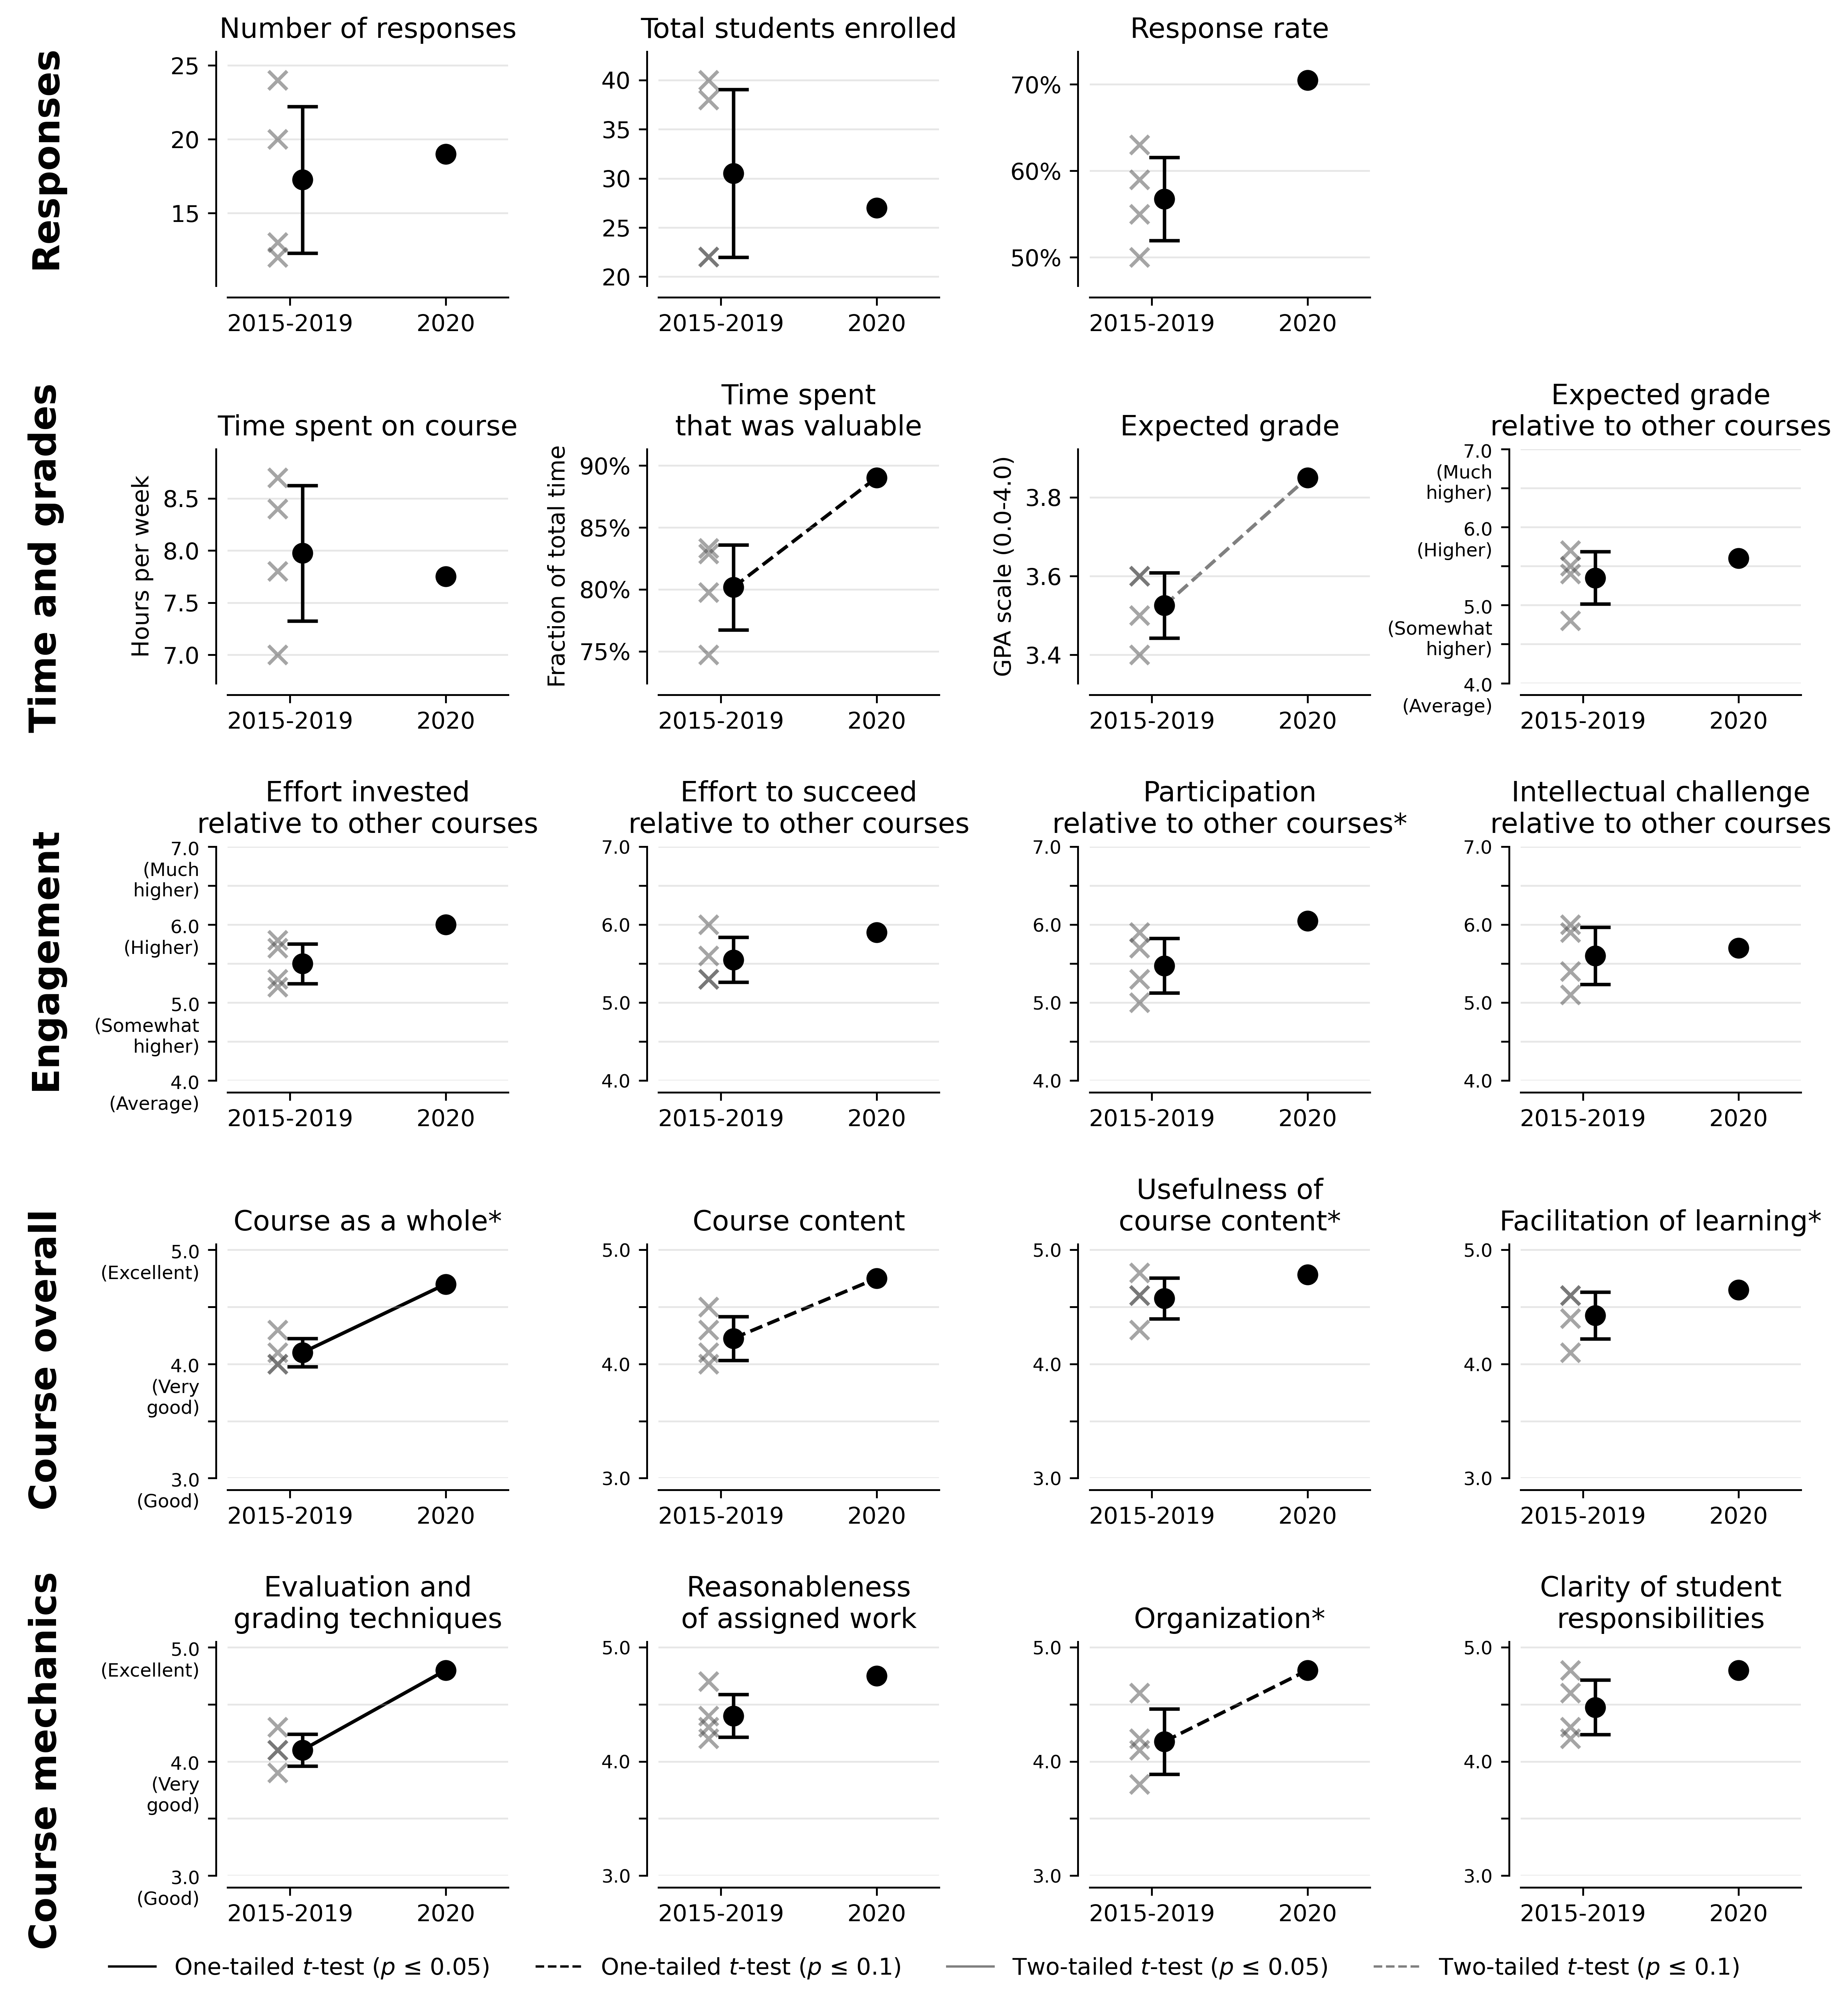

In [ ]:
# Plot parameters
subplot_n = 0
nrows = 5
ncols = 4

def subplot_eval_question(y,x,subplot_n,category,question,column,label,
                          y_axis_percent=False,y_axis_scale=None,ylabel=None,drop_y=False,
                          ttest_one_sided=True,print_diagnostics=False):
  subplot_n += 1
  plt.subplot(y,x,subplot_n)
  if type(question) == str:
    current_question = question
    past_question = question
  elif type(question) == list:
    current_question = question[0]
    past_question = question[1]
  if type(current_question) == str:
    current_avg = np.mean([eval_df.loc[(name,category,current_question)][column] for name in current_final_eval_names])
  elif type(current_question) == list:
    current_avg = np.mean([np.mean([eval_df.loc[(name,category,this_question)][column] for name in current_final_eval_names]) for this_question in current_question])
  if type(past_question) == str:
    past_values = np.array([eval_df.loc[(name,category,past_question)][column] for name in past_final_eval_names])
  elif type(past_question) == list:
    past_values = np.array([np.mean([eval_df.loc[(name,category,this_question)][column] for this_question in past_question]) for name in past_final_eval_names])
  if y_axis_percent:
    current_avg = 100 * current_avg
    past_values = 100 * past_values
  past_avg = np.mean(past_values)
  past_std = np.std(past_values)
  plt.scatter(np.tile(0.92,len(past_values)),past_values,s=8**2,marker='x',color='0.3',alpha=0.5,zorder=2)
  plt.errorbar(1.08,past_avg,yerr=past_std,capsize=6.5,elinewidth=1.5,capthick=1.5,marker='o',markersize=8,color='k',zorder=2)
  plt.scatter(2,current_avg,s=8**2,marker='o',color='k',zorder=2)

  if print_diagnostics:
    print(question)
    print(past_values)
    print(current_avg)

  # t-test for statistical significance in change between past years and 2020
  if ttest_one_sided: p_val = stats.ttest_ind(past_values,current_avg,alternative='less').pvalue; color = 'k'
  else:               p_val = stats.ttest_ind(past_values,current_avg,alternative='two-sided').pvalue; color = '0.5'
  if print_diagnostics: print('one-sided?',ttest_one_sided,p_val)
  if p_val <= 0.05:
    plt.plot([1.08,2],[past_avg,current_avg],ls='-',lw=1.5,c=color,zorder=1)
  elif p_val <= 0.10:
    plt.plot([1.08,2],[past_avg,current_avg],ls='--',lw=1.5,c=color,zorder=1)

  plt.gca().spines['left'].set_position(('outward',5))
  plt.gca().spines['bottom'].set_position(('outward',5))
  plt.gca().spines['right'].set_visible(False)
  plt.gca().spines['top'].set_visible(False)

  plt.xlim([0.6,2.4])
  if y_axis_scale == 5:
    plt.ylim(3.0,5.05)
    plt.yticks([3.0,3.5,4.0,4.5,5.0],labels=['\n3.0\n(Good)','','\n\n4.0\n(Very\ngood)','','\n5.0\n(Excellent)'],fontsize=8)
    if drop_y: plt.yticks([3.0,3.5,4.0,4.5,5.0],labels=[3.0,'',4.0,'',5.0])
  elif y_axis_scale == 7:
    plt.ylim(4.0,7.0)
    plt.yticks([4.0,4.5,5.0,5.5,6.0,6.5,7.0],labels=['\n4.0\n(Average)','','\n\n5.0\n(Somewhat\nhigher)','','\n6.0\n(Higher)','','\n\n7.0\n(Much\nhigher)'],fontsize=8)
    if drop_y: plt.yticks([4.0,4.5,5.0,5.5,6.0,6.5,7.0],labels=[4.0,'',5.0,'',6.0,'',7.0])
  else:
    current_ylim = plt.ylim()
    ylim_diff = current_ylim[1] - current_ylim[0]
    plt.ylim([current_ylim[0]-ylim_diff/10,current_ylim[1]+ylim_diff/10])
  if ylabel is not None: plt.ylabel(ylabel)
  plt.xticks([1,2],labels=['2015-2019','2020'],fontsize=10)
  plt.title(label,fontsize=12)
  plt.grid(axis='y',alpha=0.3,zorder=0)
  if y_axis_percent: plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

  return subplot_n

plt.figure(figsize=(11,12),facecolor='w',dpi=450)
subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Responses','Responses','Total responses','Number of responses',ttest_one_sided=False)
subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Responses','Responses','Total enrolled','Total students enrolled',ttest_one_sided=False)
subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Responses','Responses','Response rate','Response rate',y_axis_percent=True,ttest_one_sided=False)
subplot_n += 1
subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Time spent on course',
                                  'On average, how many hours per week have you spent on this course, including attending classes, ' +
                                  'doing readings, reviewing notes, writing papers and any other course related work?',
                                  'Median','Time spent on course',ylabel='Hours per week',ttest_one_sided=False)
subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Time spent that was valuable',
                                  '[ADDED] What percent of time spent on this course do you consider valuable?',
                                  'Median','Time spent\nthat was valuable',ylabel='Fraction of total time',y_axis_percent=True)
subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Expected grade',
                                  'What grade do you expect in this course?',
                                  'Median','Expected grade',ylabel='GPA scale (0.0-4.0)',ttest_one_sided=False)
subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Student engagement (relative to other courses)',
                                  'Do you expect your grade in this course to be:',
                                  'Median','Expected grade\nrelative to other courses',y_axis_scale=7,ttest_one_sided=False)
subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Student engagement (relative to other courses)',
                                  'The amount of effort you put into this course was:',
                                  'Median','Effort invested\nrelative to other courses',y_axis_scale=7,ttest_one_sided=False)
subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Student engagement (relative to other courses)',
                                  'The amount of effort to succeed in this course was:',
                                  'Median','Effort to succeed\nrelative to other courses',y_axis_scale=7,drop_y=True,ttest_one_sided=False)
subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Student engagement (relative to other courses)',
                                  ['Relative to similar courses taught in person, your participation in this course was:',
                                   'Your involvement in course (doing assignments, attending classes, etc.) was:'],
                                  'Median','Participation\nrelative to other courses*',y_axis_scale=7,drop_y=True)
subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Student engagement (relative to other courses)',
                                  'The intellectual challenge presented was:',
                                  'Median','Intellectual challenge\nrelative to other courses',y_axis_scale=7,drop_y=True,ttest_one_sided=False)
subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Summative items',
                                  ['The remote learning course as a whole was:',
                                   'The course as a whole was:'],
                                  'Median','Course as a whole*',y_axis_scale=5)
subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Summative items',
                                  'The course content was:',
                                  'Median','Course content',y_axis_scale=5,drop_y=True)
subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Standard formative items',
                                  [['Usefulness of reading assignments in understanding course content was:',
                                    'Usefulness of written assignments in understanding course content was:',
                                    'Usefulness of online resources in understanding course content was:'],
                                  'Relevance and usefulness of course content were:'],
                                  'Median','Usefulness of\ncourse content*',y_axis_scale=5,drop_y=True)
subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Standard formative items',
                                  ['The effectiveness of this remote course in facilitating my learning was:',
                                   'Amount you learned in the course was:'],
                                  'Median','Facilitation of learning*',y_axis_scale=5,drop_y=True)
subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Standard formative items',
                                  'Evaluative and grading techniques (tests, papers, projects, etc.) were:',
                                  'Median','Evaluation and\ngrading techniques',y_axis_scale=5)
subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Standard formative items',
                                  'Reasonableness of assigned work was:',
                                  'Median','Reasonableness\nof assigned work',y_axis_scale=5,drop_y=True)
subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Standard formative items',
                                  ['Organization of materials online was:',
                                   'Course organization was:'],
                                  'Median','Organization*',y_axis_scale=5,drop_y=True)
subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Standard formative items',
                                  'Clarity of student responsibilities and requirements was:',
                                  'Median','Clarity of student\nresponsibilities',y_axis_scale=5,drop_y=True)
# subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Summative items',
#                                   "The instructor's contribution to the course was:",
#                                   'Median',"Instructor's contribution\nto the course",y_axis_scale=5)
# subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Summative items',
#                                   "The instructor's effectiveness in teaching the subject matter was:",
#                                   'Median',"Effectiveness\nof instructor's teaching",y_axis_scale=5,drop_y=True)
# subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Standard formative items',
#                                   ['Quality/helpfulness of instructor feedback was:',
#                                    ['Explanations by instructor were:',
#                                     "Instructor's ability to present alternative explanations when needed was:",
#                                     "Instructor's interest in whether students learned was:",
#                                     'Answers to student questions were:']],
#                                   'Median','Quality of instructor\nanswers and feedback*',y_axis_scale=5,drop_y=True)
plt.tight_layout(h_pad=2.2)
plt.gcf().subplots_adjust(left=0.13,bottom=0.06)

def annotate_rows(x,y,label):
  plt.annotate(label,xy=(x,y),xycoords='figure fraction',fontsize=16,fontweight='bold',rotation=90,
               horizontalalignment='right',verticalalignment='center')

x_val = 0.035
top_y = 0.92
delta_y = 0.20
annotate_rows(x_val,top_y,'Responses')
annotate_rows(x_val,top_y-1*delta_y,'Time and grades')
annotate_rows(x_val,top_y-2*delta_y,'Engagement')
annotate_rows(x_val,top_y-3*delta_y,'Course overall')
annotate_rows(x_val,top_y-4*delta_y,'Course mechanics')
# annotate_rows(x_val,top_y-5*delta_y,'Instructor')

leg_handles = []
leg_handles.append(plt.plot([np.NaN,np.NaN],[np.NaN,np.NaN],c='k',ls='-',lw=1)[0])
leg_handles.append(plt.plot([np.NaN,np.NaN],[np.NaN,np.NaN],c='k',ls='--',lw=1)[0])
leg_handles.append(plt.plot([np.NaN,np.NaN],[np.NaN,np.NaN],c='0.5',ls='-',lw=1)[0])
leg_handles.append(plt.plot([np.NaN,np.NaN],[np.NaN,np.NaN],c='0.5',ls='--',lw=1)[0])
leg_labels = [r'One-tailed $t$-test ($p$ ≤ 0.05)',r'One-tailed $t$-test ($p$ ≤ 0.1)',
              r'Two-tailed $t$-test ($p$ ≤ 0.05)',r'Two-tailed $t$-test ($p$ ≤ 0.1)']
plt.gcf().legend(leg_handles,leg_labels,loc='lower center',ncol=4,frameon=False)

plt.savefig(export_to + 'Course evaluations (full version).pdf',bbox_inches='tight')

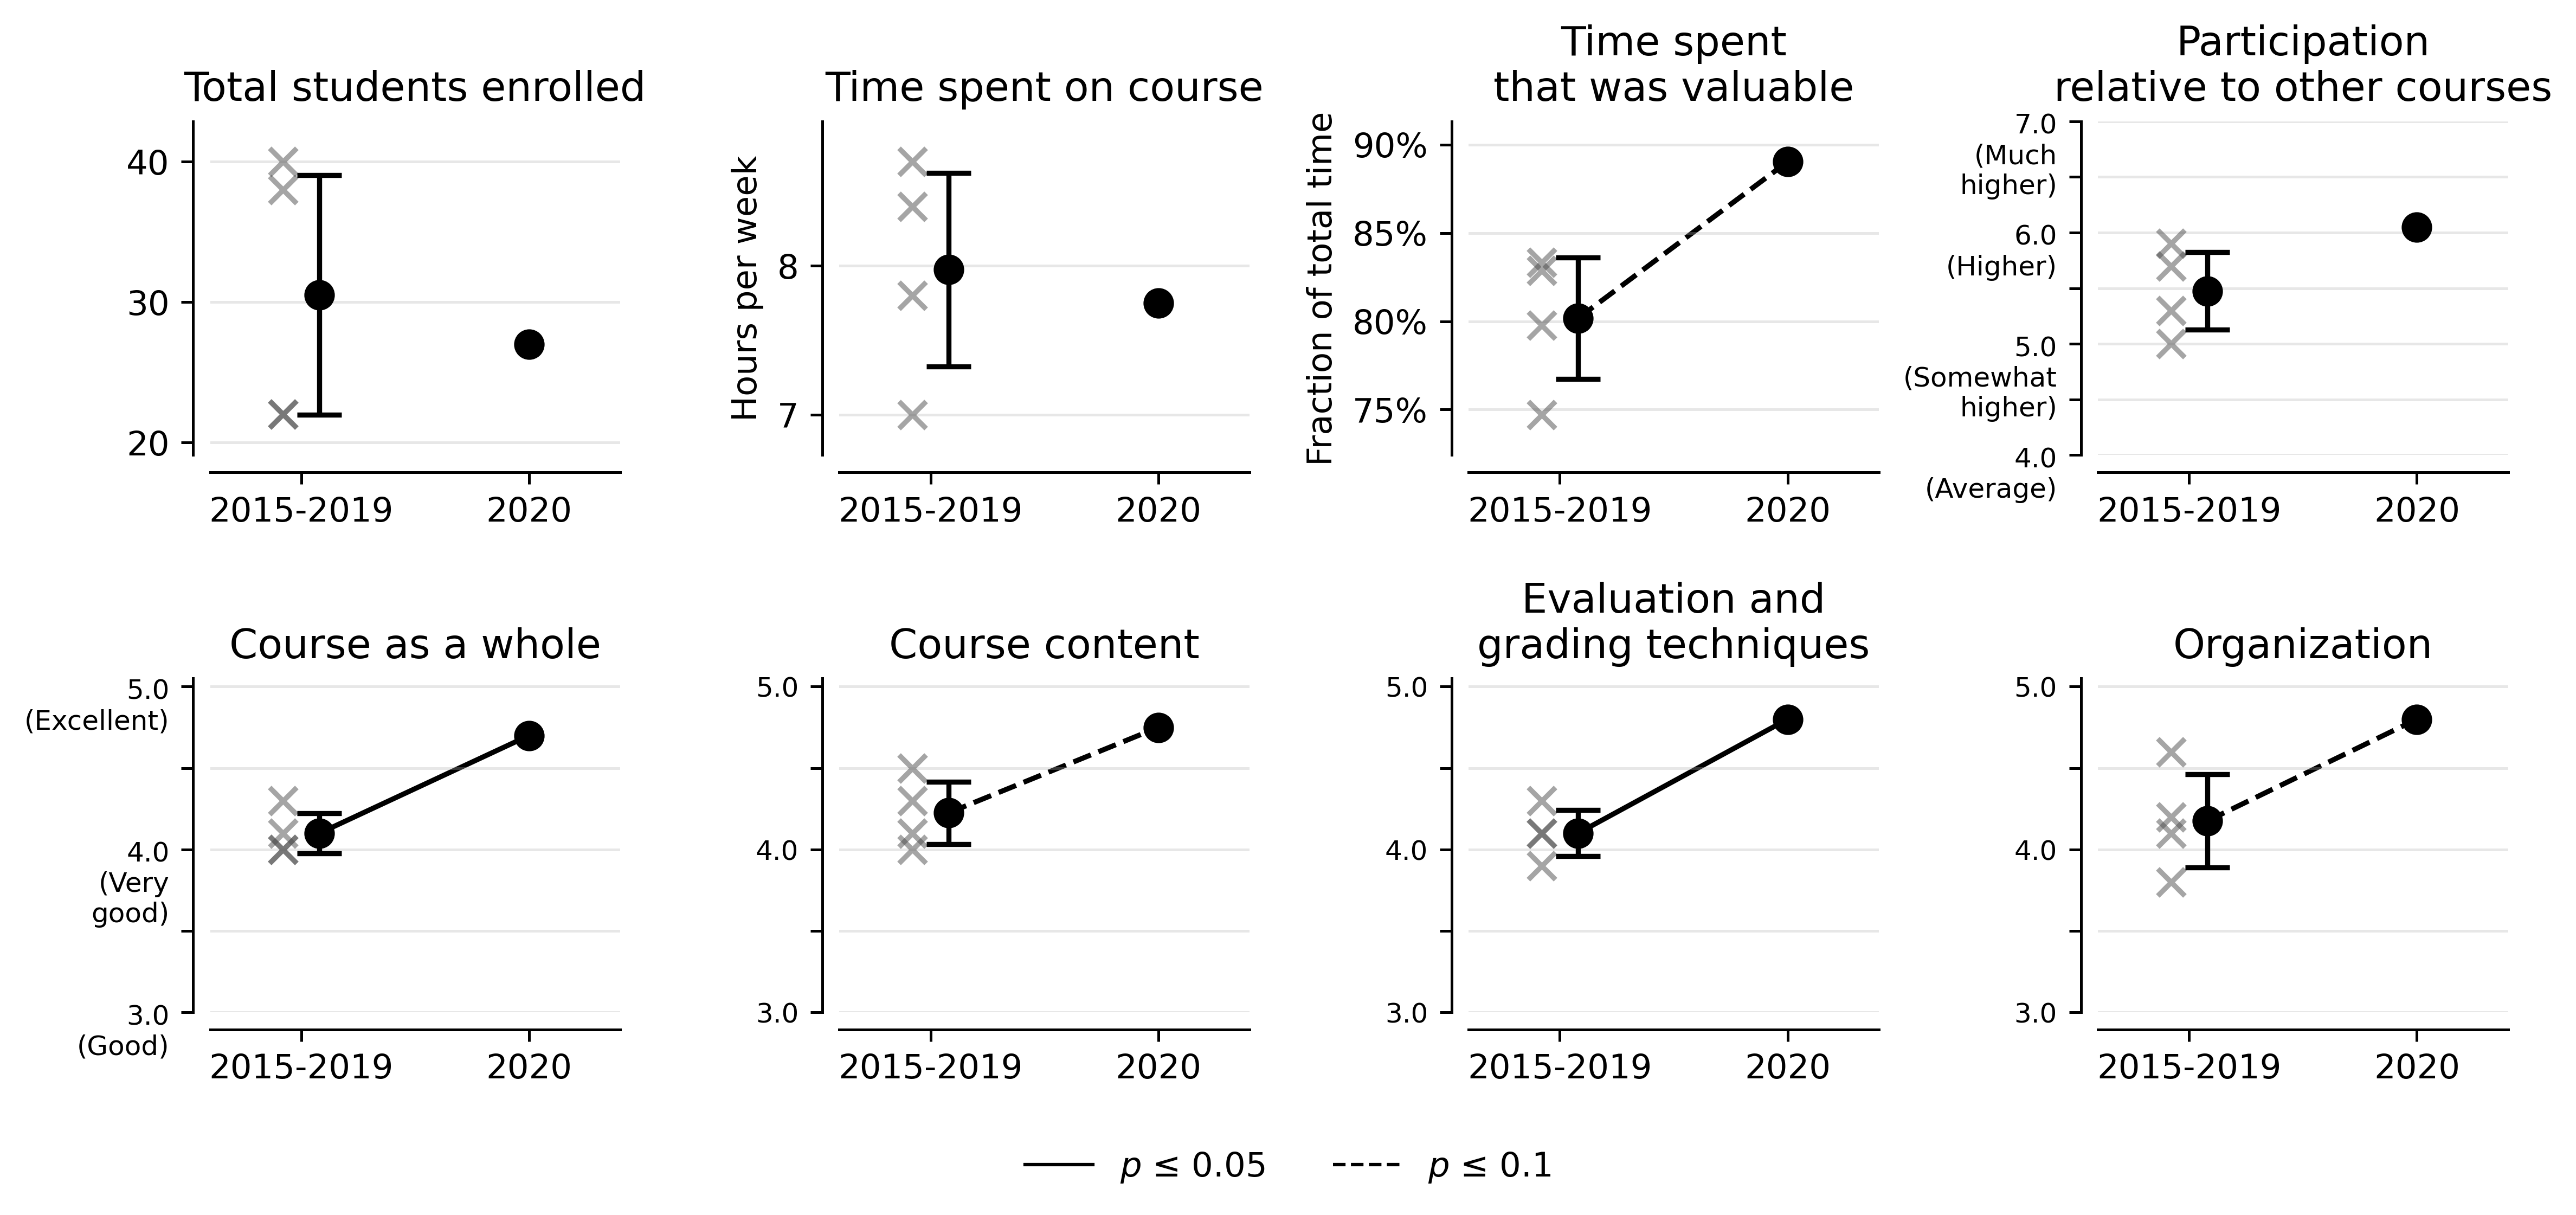

In [ ]:
# Small version of plot

# Parameters
subplot_n = 0
nrows = 2
ncols = 4

plt.figure(figsize=(11,5.0),facecolor='w',dpi=450)
subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Responses','Responses','Total enrolled','Total students enrolled')
subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Time spent on course',
                                  'On average, how many hours per week have you spent on this course, including attending classes, ' +
                                  'doing readings, reviewing notes, writing papers and any other course related work?',
                                  'Median','Time spent on course',ylabel='Hours per week')
subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Time spent that was valuable',
                                  '[ADDED] What percent of time spent on this course do you consider valuable?',
                                  'Median','Time spent\nthat was valuable',ylabel='Fraction of total time',y_axis_percent=True)
subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Student engagement (relative to other courses)',
                                  ['Relative to similar courses taught in person, your participation in this course was:',
                                   'Your involvement in course (doing assignments, attending classes, etc.) was:'],
                                  'Median','Participation\nrelative to other courses',y_axis_scale=7)
subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Summative items',
                                  ['The remote learning course as a whole was:',
                                   'The course as a whole was:'],
                                  'Median','Course as a whole',y_axis_scale=5)
subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Summative items',
                                  'The course content was:',
                                  'Median','Course content',y_axis_scale=5,drop_y=True)
subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Standard formative items',
                                  'Evaluative and grading techniques (tests, papers, projects, etc.) were:',
                                  'Median','Evaluation and\ngrading techniques',y_axis_scale=5,drop_y=True)
subplot_n = subplot_eval_question(nrows,ncols,subplot_n,'Standard formative items',
                                  ['Organization of materials online was:',
                                   'Course organization was:'],
                                  'Median','Organization',y_axis_scale=5,drop_y=True)
plt.tight_layout(h_pad=2.2)
plt.gcf().subplots_adjust(left=0.13,bottom=0.16)

leg_handles = []
leg_handles.append(plt.plot([np.NaN,np.NaN],[np.NaN,np.NaN],c='k',ls='-',lw=1)[0])
leg_handles.append(plt.plot([np.NaN,np.NaN],[np.NaN,np.NaN],c='k',ls='--',lw=1)[0])
# leg_handles.append(plt.plot([np.NaN,np.NaN],[np.NaN,np.NaN],c='0.5',ls='-',lw=1)[0])
# leg_handles.append(plt.plot([np.NaN,np.NaN],[np.NaN,np.NaN],c='0.5',ls='--',lw=1)[0])
leg_labels = [r'$p$ ≤ 0.05',r'$p$ ≤ 0.1']
            # r'Two-tailed $t$-test ($p$ ≤ 0.05)',r'Two-tailed $t$-test ($p$ ≤ 0.1)'
plt.gcf().legend(leg_handles,leg_labels,loc='lower center',ncol=len(leg_labels),frameon=False)

plt.savefig(export_to + 'Course evaluations (small version).pdf',bbox_inches='tight')
plt.savefig(export_to + 'Course evaluations (small version).tiff',bbox_inches='tight')

### Prior coding experience vs. grades (Fig. S3)

In [ ]:
# See above for provenance of metrics
prior_experience = main_df['Assignment #0 - prior coding experience (out of 5; new version)'].sort_index()
grade_diff_recalc = grades_recalc - grades_recalc.mean()
grade_diff_std = grade_diff_recalc / grade_diff_recalc.std()

# Dichotomize by less vs. more experience
grades_less_experience = grade_diff_recalc[prior_experience < 3]
grades_more_experience = grade_diff_recalc[prior_experience >= 3]
grades_less_experience_std = grade_diff_std[prior_experience < 3]
grades_more_experience_std = grade_diff_std[prior_experience >= 3]

# Calculate IQR(25%-75%)
iqr_less_experience = [grades_less_experience.quantile(q=0.25),grades_less_experience.quantile(q=0.75)]
iqr_more_experience = [grades_more_experience.quantile(q=0.25),grades_more_experience.quantile(q=0.75)]
iqr_less_experience_std = [grades_less_experience_std.quantile(q=0.25),grades_less_experience_std.quantile(q=0.75)]
iqr_more_experience_std = [grades_more_experience_std.quantile(q=0.25),grades_more_experience_std.quantile(q=0.75)]

In [ ]:
# Use t-test to test if average grades within dichotomized samples are different
# Because p >> 0.05, cannot reject null hypothesis that two samples are drawn from the same population or distribution
t, p = stats.ttest_ind(grades_less_experience,grades_more_experience)
print(t, p)

-0.14350095290025472 0.8871444197366927


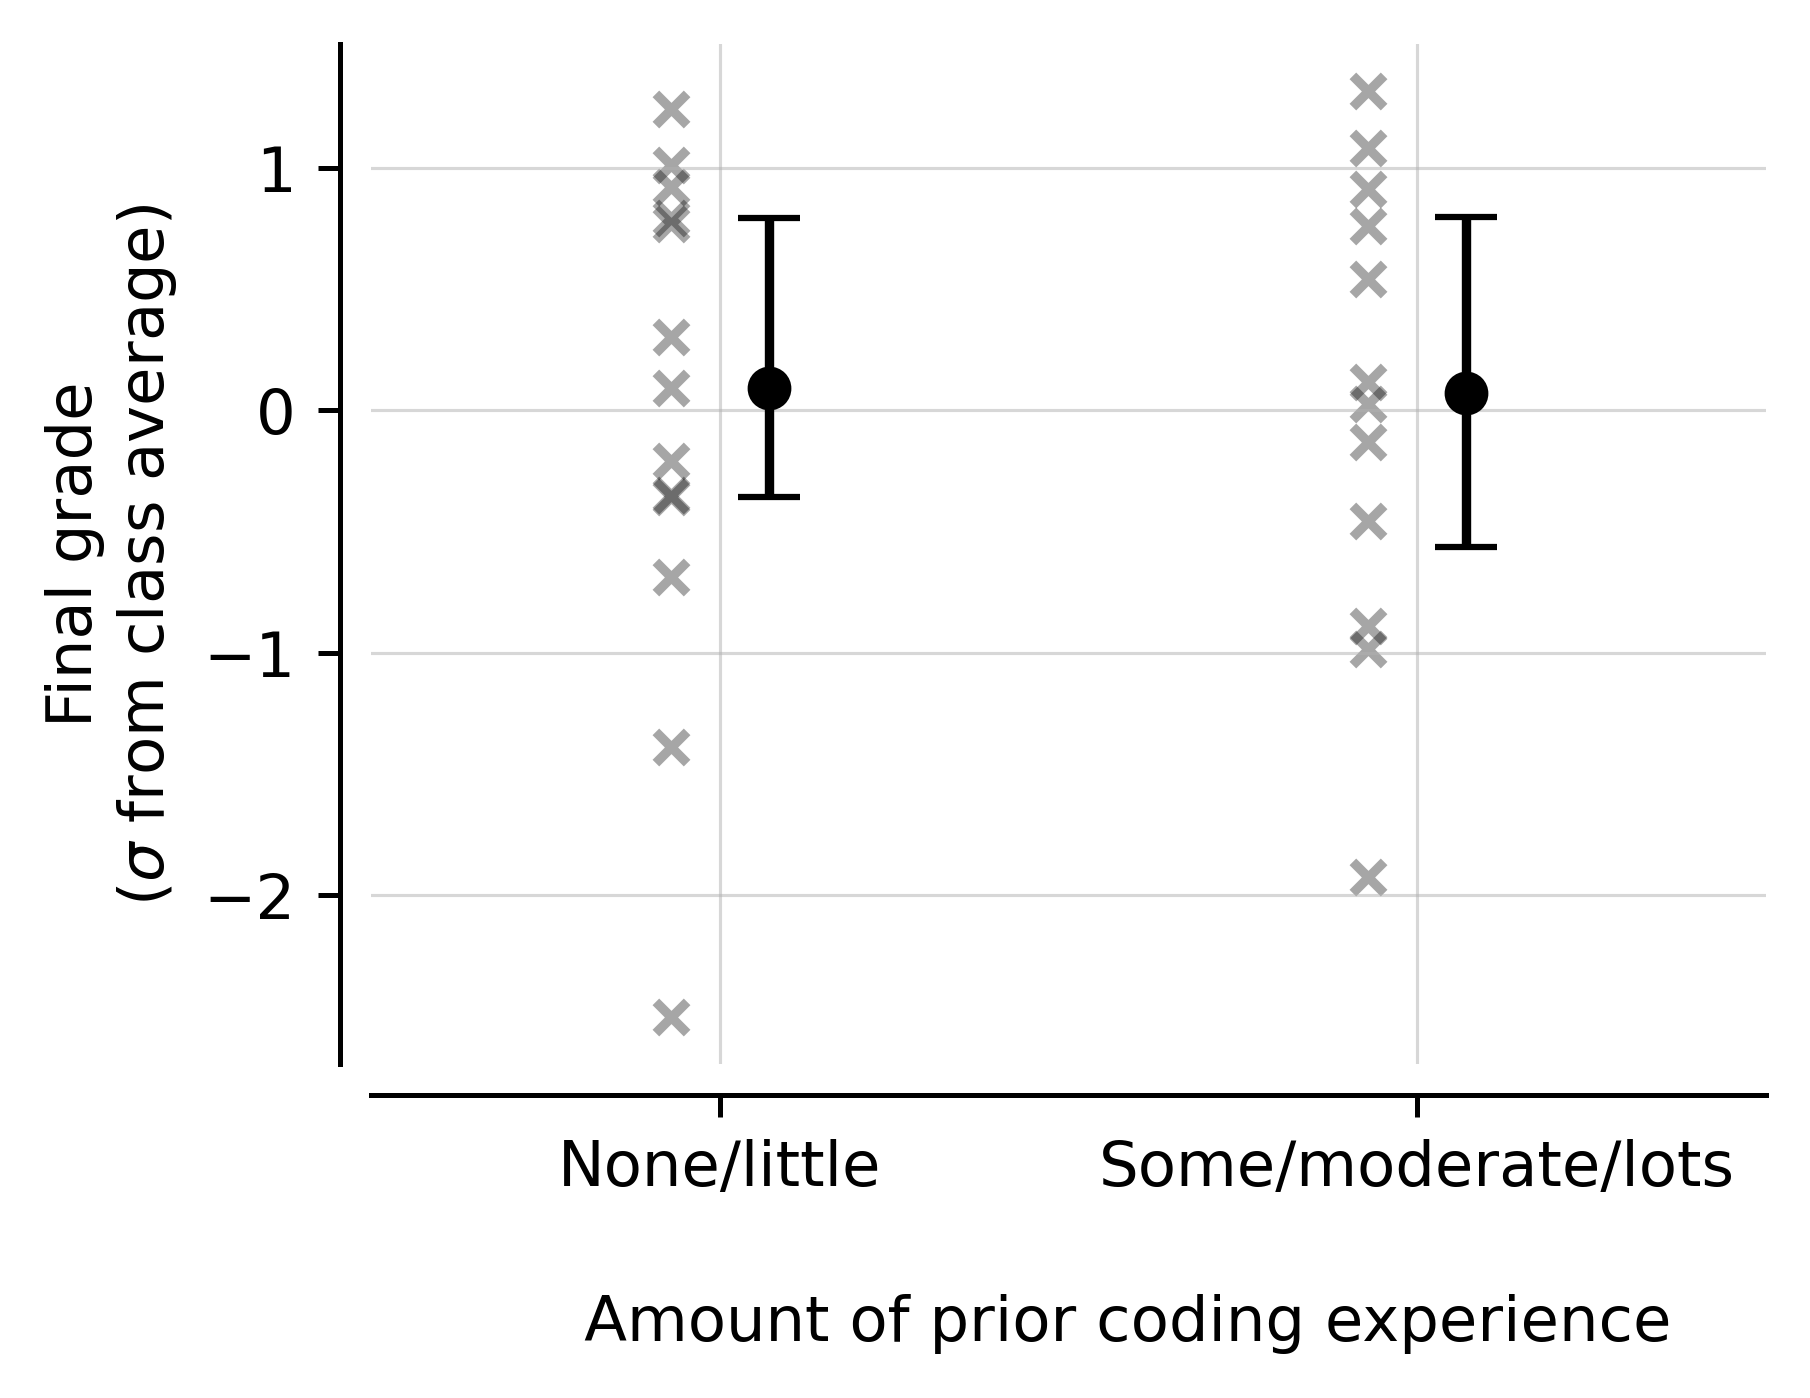

In [ ]:
# See above for provenance of metrics
grade_diff_std = grade_diff_recalc / grade_diff_recalc.std()

# Dichotomize by less vs. more experience
grades_less_experience_std = grade_diff_std[prior_experience < 3]
grades_more_experience_std = grade_diff_std[prior_experience >= 3]

# Calculate IQR(25%-75%)
iqr_less_experience_std = [grades_less_experience_std.quantile(q=0.25),grades_less_experience_std.quantile(q=0.75)]
iqr_more_experience_std = [grades_more_experience_std.quantile(q=0.25),grades_more_experience_std.quantile(q=0.75)]

# Basic plots
plt.figure(figsize=(4,3),facecolor='w',dpi=450)
plt.errorbar(1.07,grades_less_experience_std.median(),
             yerr=np.array([[grades_less_experience_std.median()-iqr_less_experience_std[0]],
                            [iqr_less_experience_std[1]-grades_less_experience_std.median()]]),
             marker='o',mfc='k',mec='k',ecolor='k',capsize=5)
plt.errorbar(2.07,grades_more_experience_std.median(),
             yerr=np.array([[grades_more_experience_std.median()-iqr_more_experience_std[0]],
                            [iqr_more_experience_std[1]-grades_more_experience_std.median()]]),
             marker='o',mfc='k',mec='k',ecolor='k',capsize=5)
for pt in grades_less_experience_std: plt.scatter(0.93,pt,s=25,marker='x',c='k',alpha=0.35)
for pt in grades_more_experience_std: plt.scatter(1.93,pt,s=25,marker='x',c='k',alpha=0.35)
plt.xlim([0.5,2.5])
plt.xticks([1,2],['None/little','Some/moderate/lots'])
plt.xlabel('\n      Amount of prior coding experience')
plt.ylabel('Final grade\n($\sigma$ from class average)')
# plt.ylim([-0.9,0.9])
plt.grid(alpha=0.5,lw=0.5,zorder=1)
drop_spines()

plt.savefig(export_to + 'Prior coding experience vs. grades.pdf',bbox_inches='tight')